In [2]:
import pandas as pd
from astropy.io import fits
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
from astroquery.gaia import Gaia
from matplotlib import pyplot as plt
import time
from scipy.optimize import brentq
from scipy.stats.mstats import mquantiles
from scipy.stats import norm

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [74]:
start = time.time()
job = Gaia.launch_job_async(query="SELECT TOP 1000000 * FROM gaiadr2.gaia_source WHERE parallax <= 800 \
                    ORDER BY parallax DESC",\
                    verbose=False, dump_to_file=True, output_format='csv')
print job

end = time.time()
print(end - start)

Jobid: 1529969136454O
Phase: COMPLETED
Owner: None
Output file: async_20180625162536.csv
Results: None
3029.15624809


In [3]:
k = pd.read_csv('async_20180625162536.csv')
gaia_id = k['source_id'].values
gra,gdec = k['ra'].values,k['dec'].values
gpmra,gpmde = k['pmra'].values,k['pmdec'].values
ggmag,gbpflux,grpflux = k['phot_g_mean_mag'].values,k['phot_bp_mean_flux'].values,k['phot_rp_mean_flux'].values
gbpmag,grpmag,gbprpmag = k['phot_bp_mean_mag'].values,k['phot_rp_mean_mag'].values,k['bp_rp'].values
gparallax,gparaerror = k['parallax'].values,k['parallax_error'].values
l,b,ecl_lon,ecl_lat,radius,rv = k['l'].values,k['b'].values,k['ecl_lon'].values,k['ecl_lat'].values,\
    k['radius_val'].values,k['radial_velocity'].values
teff,lum,color = k['teff_val'].values,k['lum_val'].values,k['astrometric_pseudo_colour'].values

frac_para_error = gparaerror/gparallax
omega,sigma = gparallax/1000,gparaerror/1000

In [4]:
frac_para_error = gparaerror/gparallax

# None of these are missing a parallax solution:
print 'Where isnan:',np.where(np.isnan(gparallax))

print 'max parallax:',np.max(gparallax),'min parallax:',np.min(gparallax)

# But most of them are missing the rest of the full solution:
print 'Where isnan:'
print 'Teff',np.where(np.isnan(teff))[0].shape
print 'Lum',np.where(np.isnan(lum))[0].shape
print 'RV',np.where(np.isnan(rv))[0].shape
print 'Radius',np.where(np.isnan(radius))[0].shape
print 'Gmag',np.where(np.isnan(ggmag))[0].shape
print 'Gbp',np.where(np.isnan(gbpmag))[0].shape
print 'Grp',np.where(np.isnan(grpmag))[0].shape
print 'Gbp-Grp mag',np.where(np.isnan(gbprpmag))[0].shape

print 'Max and min f:',np.max(frac_para_error),np.min(frac_para_error)

print np.where(k['phot_proc_mode'].values==2)[0].shape

Where isnan: (array([], dtype=int64),)
max parallax: 796.124431419 min parallax: 8.94966556929
Where isnan:
Teff (678622,)
Lum (904480,)
RV (902433,)
Radius (904480,)
Gmag (0,)
Gbp (150181,)
Grp (149467,)
Gbp-Grp mag (152451,)
Max and min f: 0.605316790776 8.85532734304e-05
(117077,)


## Remove all sources without Gbp-Grp colors

In [5]:
m=k.drop(np.where(np.isnan(gbprpmag))[0],axis=0)
m=m.reset_index()
m = m.drop(['index'], axis=1)
m

solution_id                   designation  \
0       1635721458409799680  Gaia DR2 5853498713160606720   
1       1635721458409799680  Gaia DR2 1824801659879180544   
2       1635721458409799680  Gaia DR2 5978137354097288064   
3       1635721458409799680  Gaia DR2 4145394651996744704   
4       1635721458409799680  Gaia DR2 4090109764196360576   
5       1635721458409799680  Gaia DR2 4043588155928790528   
6       1635721458409799680  Gaia DR2 4046472106243728128   
7       1635721458409799680  Gaia DR2 4147859001074741888   
8       1635721458409799680  Gaia DR2 4049336059085668608   
9       1635721458409799680  Gaia DR2 4119879724447178624   
10      1635721458409799680  Gaia DR2 4050950657605998080   
11      1635721458409799680  Gaia DR2 4063051466107114496   
12      1635721458409799680  Gaia DR2 4038950244078680832   
13      1635721458409799680  Gaia DR2 4048896666737862656   
14      1635721458409799680  Gaia DR2 4048767474113708160   
15      1635721458409799680  Gaia DR2 2031625535133232768   
16      1635721458409799680  Gaia DR2 4089950541155819008   
17      1635721458409799680  Gaia DR2 4042723042164592128   
18      1635721458409799680  Gaia DR2 4118677756385143424   
19      1635721458409799680  Gaia DR2 4472832130942575872   
20      1635721458409799680  Gaia DR2 4117407579926310144   
21      1635721458409799680  Gaia DR2 4135193451742436864   
22      1635721458409799680  Gaia DR2 4077272484929328256   
23      1635721458409799680  Gaia DR2 4090344127699617920   
24      1635721458409799680  Gaia DR2 4064649198063448448   
25      1635721458409799680  Gaia DR2 4148058734300260224   
26      1635721458409799680  Gaia DR2 4307759121663604608   
27      1635721458409799680  Gaia DR2 4052244714083700352   
28      1635721458409799680  Gaia DR2 4147944694300162944   
29      1635721458409799680  Gaia DR2 4053037560744822016   
...                     ...                           ...   
847519  1635721458409799680  Gaia DR2 6058970670126598016   
847520  1635721458409799680  Gaia DR2 4145083936821049856   
847521  1635721458409799680  Gaia DR2 5986525292106292480   
847522  1635721458409799680  Gaia DR2 3630354642049110784   
847523  1635721458409799680  Gaia DR2 5950042396773144704   
847524  1635721458409799680  Gaia DR2 5865921540949980800   
847525  1635721458409799680  Gaia DR2 4758360663417267712   
847526  1635721458409799680  Gaia DR2 4236298592497310592   
847527  1635721458409799680  Gaia DR2 5254448391337136384   
847528  1635721458409799680  Gaia DR2 5782218508156944128   
847529  1635721458409799680  Gaia DR2 3027170744973947648   
847530  1635721458409799680  Gaia DR2 2018264647771334528   
847531  1635721458409799680  Gaia DR2 6110066246757712000   
847532  1635721458409799680  Gaia DR2 4116954100132046080   
847533  1635721458409799680  Gaia DR2 5819929145659779456   
847534  1635721458409799680  Gaia DR2 2339648735456227328   
847535  1635721458409799680  Gaia DR2 2025189234590060800   
847536  1635721458409799680  Gaia DR2 1833899156500646912   
847537  1635721458409799680  Gaia DR2 4113329899238104064   
847538  1635721458409799680  Gaia DR2 5714371493895176064   
847539  1635721458409799680  Gaia DR2 2177371539434689536   
847540  1635721458409799680  Gaia DR2 4092988384401360000   
847541  1635721458409799680  Gaia DR2 2047111778440125824   
847542  1635721458409799680  Gaia DR2 1827959079288949760   
847543  1635721458409799680  Gaia DR2 3938694918369774848   
847544  1635721458409799680  Gaia DR2 6784503380700679936   
847545  1635721458409799680  Gaia DR2 6033248935646851072   
847546  1635721458409799680  Gaia DR2 3062246368485918336   
847547  1635721458409799680  Gaia DR2 5877656147514690816   
847548  1635721458409799680  Gaia DR2 5339621990871151360   

                  source_id  random_index  ref_epoch          ra  ra_error  \
0       5853498713160606720     521085047     2015.5  217.393466  0.057653   
1       1824801659879180544    1636241798     2015.5  297.367581  1.605905   

In [6]:
print 'Gbp-Grp mag',np.where(np.isnan(m['bp_rp'].values))[0].shape

Gbp-Grp mag (0,)


## Distances

In [6]:
gaia_id = m['source_id'].values
gra,gdec = m['ra'].values,m['dec'].values
gpmra,gpmde = m['pmra'].values,m['pmdec'].values
ggmag,gbpflux,grpflux = m['phot_g_mean_mag'].values,m['phot_bp_mean_flux'].values,m['phot_rp_mean_flux'].values
gbpmag,grpmag,gbprpmag = m['phot_bp_mean_mag'].values,m['phot_rp_mean_mag'].values,m['bp_rp'].values
gparallax,gparaerror = m['parallax'].values,m['parallax_error'].values
#l,b,ecl_lon,ecl_lat,radius,rv = k['l'].values,k['b'].values,k['ecl_lon'].values,k['ecl_lat'].values,\
#    k['radius_val'].values,k['radial_velocity'].values
#teff,lum,color = k['teff_val'].values,k['lum_val'].values,k['astrometric_pseudo_colour'].values

frac_para_error = gparaerror/gparallax
omega,sigma = gparallax/1000,gparaerror/1000

Max and min f: 0.605316790776 8.85532734304e-05
Number above 0.1: 314098


<IPython.core.display.Javascript object>


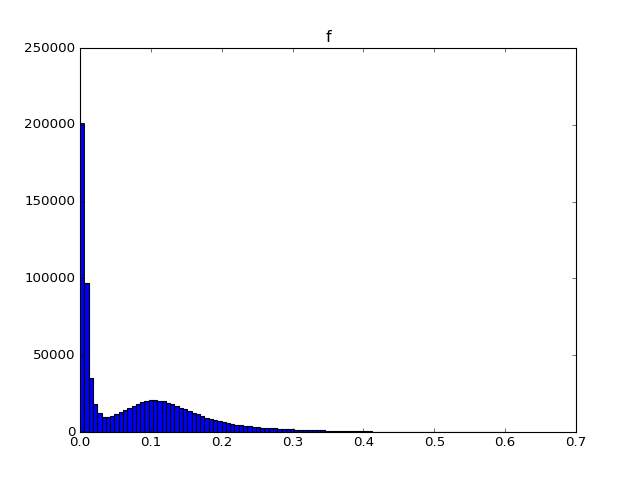

In [7]:
print 'Max and min f:',np.max(frac_para_error),np.min(frac_para_error)
print 'Number above 0.1:',np.where(frac_para_error>0.1)[0].shape[0]

%matplotlib notebook
plt.hist(frac_para_error,bins=100)
plt.title('f')
plt.show()

### Computing distance and FWHM:
Gaia parallaxes have a zero-point shift of -0.029 mas.  So 0.029 mas must be added to the measured parallax to get accurate distances.  (Luri et. al. 2018 (https://arxiv.org/abs/1804.09376))<br>
Also, the parallax must be converted to arcseconds to get the distance in parcsecs.

In [162]:
start = time.time()

omega,sigma = (gparallax+0.029)/1000,gparaerror/1000
gdist = np.array([])

print 'Computing distances'
count=0
for i in range(len(omega)):
    coeff = np.array([(1./L),(-2),((omega[i])/((sigma[i])**2)),-(1./((sigma[i])**2))])
    g = np.roots(coeff)
    # Find the number of real roots:
    reals = np.isreal(g)
    realsum = np.sum(reals)
    # If there is one real root, that root is the  mode:
    if realsum == 1:
        gd = np.real(g[np.where(reals)[0]])
    # If all roots are real:
    elif realsum == 3:
        if omega[i] >= 0:
            # Take the smallest root:
            gd = np.min(g)
        elif omega[i] < 0:
            # Take the positive root (there should be only one):
            gd = g[np.where(g>0)[0]]
    gdist = np.append(gdist,gd)
    
    count = count+1
    mod=count%100000
    if mod==0:
        print 'Finished ',count,' sources'
print 'Finished distances for ',gdist.shape[0]

end = time.time()
print(end - start)

print 'Computing FWHM'

count=0
rmax = 1e6
fwhm_lo,fwhm_hi = np.array([]),np.array([])
for i in range(len(omega)):
    rmode = gdist[i]
    M = (rmode**2*np.exp(-rmode/L)/sigma[i])*np.exp((-1./(2*(sigma[i])**2))*(omega[i]-(1./rmode))**2)
    lo = brentq(lambda x: 2*np.log(x)-(x/L)-(((omega[i]-(1./x))**2)/(2*sigma[i]**2)) \
               +np.log(2)-np.log(M)-np.log(sigma[i]), 0.001, rmode)
    hi = brentq(lambda x: 2*np.log(x)-(x/L)-(((omega[i]-(1./x))**2)/(2*sigma[i]**2)) \
               +np.log(2)-np.log(M)-np.log(sigma[i]), rmode, rmax)
    fwhm_lo,fwhm_hi = np.append(fwhm_lo,lo),np.append(fwhm_hi,hi)
    
    count = count+1
    mod=count%100000
    if mod==0:
        print 'Finished ',count,' sources'

print 'Finished FWHM for ',fwhm_lo.shape[0]
end = time.time()
print(end - start)

Computing distances
Finished  100000  sources
Finished  200000  sources
Finished  300000  sources
Finished  400000  sources
Finished  500000  sources
Finished  600000  sources
Finished  700000  sources
Finished  800000  sources
Finished distances for  847549
1059.87764001
Computing FWHM
Finished  100000  sources
Finished  200000  sources
Finished  300000  sources
Finished  400000  sources
Finished  500000  sources
Finished  600000  sources
Finished  700000  sources
Finished  800000  sources
Finished FWHM for  847549
3257.66336489


In [167]:
print np.where(gdist>=2000)[0].shape

(5637,)


<IPython.core.display.Javascript object>


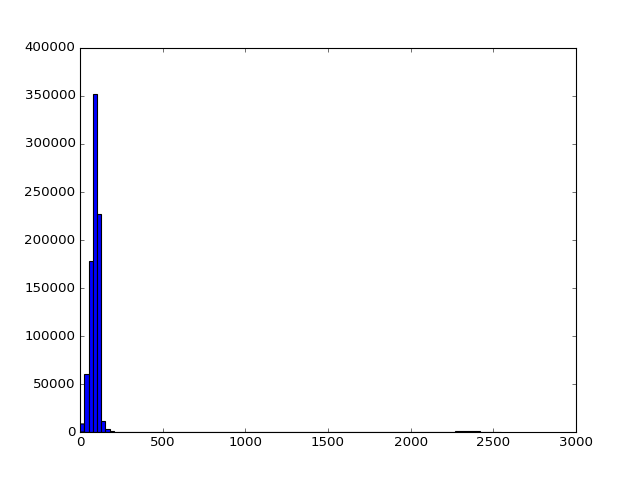

In [168]:
%matplotlib notebook
plt.hist(gdist,bins=100)
plt.show()

In [208]:
# Make new columns in dataframe and populate with new data:
m['dist'],m['dist_fwhm_lo'],m['dist_fwhm_hi'] = pd.Series(gdist, index=m.index),\
    pd.Series(fwhm_lo, index=m.index),pd.Series(fwhm_hi, index=m.index)
m

solution_id                   designation  \
0       1635721458409799680  Gaia DR2 5853498713160606720   
1       1635721458409799680  Gaia DR2 1824801659879180544   
2       1635721458409799680  Gaia DR2 5978137354097288064   
3       1635721458409799680  Gaia DR2 4145394651996744704   
4       1635721458409799680  Gaia DR2 4090109764196360576   
5       1635721458409799680  Gaia DR2 4043588155928790528   
6       1635721458409799680  Gaia DR2 4046472106243728128   
7       1635721458409799680  Gaia DR2 4147859001074741888   
8       1635721458409799680  Gaia DR2 4049336059085668608   
9       1635721458409799680  Gaia DR2 4119879724447178624   
10      1635721458409799680  Gaia DR2 4050950657605998080   
11      1635721458409799680  Gaia DR2 4063051466107114496   
12      1635721458409799680  Gaia DR2 4038950244078680832   
13      1635721458409799680  Gaia DR2 4048896666737862656   
14      1635721458409799680  Gaia DR2 4048767474113708160   
15      1635721458409799680  Gaia DR2 2031625535133232768   
16      1635721458409799680  Gaia DR2 4089950541155819008   
17      1635721458409799680  Gaia DR2 4042723042164592128   
18      1635721458409799680  Gaia DR2 4118677756385143424   
19      1635721458409799680  Gaia DR2 4472832130942575872   
20      1635721458409799680  Gaia DR2 4117407579926310144   
21      1635721458409799680  Gaia DR2 4135193451742436864   
22      1635721458409799680  Gaia DR2 4077272484929328256   
23      1635721458409799680  Gaia DR2 4090344127699617920   
24      1635721458409799680  Gaia DR2 4064649198063448448   
25      1635721458409799680  Gaia DR2 4148058734300260224   
26      1635721458409799680  Gaia DR2 4307759121663604608   
27      1635721458409799680  Gaia DR2 4052244714083700352   
28      1635721458409799680  Gaia DR2 4147944694300162944   
29      1635721458409799680  Gaia DR2 4053037560744822016   
...                     ...                           ...   
847519  1635721458409799680  Gaia DR2 6058970670126598016   
847520  1635721458409799680  Gaia DR2 4145083936821049856   
847521  1635721458409799680  Gaia DR2 5986525292106292480   
847522  1635721458409799680  Gaia DR2 3630354642049110784   
847523  1635721458409799680  Gaia DR2 5950042396773144704   
847524  1635721458409799680  Gaia DR2 5865921540949980800   
847525  1635721458409799680  Gaia DR2 4758360663417267712   
847526  1635721458409799680  Gaia DR2 4236298592497310592   
847527  1635721458409799680  Gaia DR2 5254448391337136384   
847528  1635721458409799680  Gaia DR2 5782218508156944128   
847529  1635721458409799680  Gaia DR2 3027170744973947648   
847530  1635721458409799680  Gaia DR2 2018264647771334528   
847531  1635721458409799680  Gaia DR2 6110066246757712000   
847532  1635721458409799680  Gaia DR2 4116954100132046080   
847533  1635721458409799680  Gaia DR2 5819929145659779456   
847534  1635721458409799680  Gaia DR2 2339648735456227328   
847535  1635721458409799680  Gaia DR2 2025189234590060800   
847536  1635721458409799680  Gaia DR2 1833899156500646912   
847537  1635721458409799680  Gaia DR2 4113329899238104064   
847538  1635721458409799680  Gaia DR2 5714371493895176064   
847539  1635721458409799680  Gaia DR2 2177371539434689536   
847540  1635721458409799680  Gaia DR2 4092988384401360000   
847541  1635721458409799680  Gaia DR2 2047111778440125824   
847542  1635721458409799680  Gaia DR2 1827959079288949760   
847543  1635721458409799680  Gaia DR2 3938694918369774848   
847544  1635721458409799680  Gaia DR2 6784503380700679936   
847545  1635721458409799680  Gaia DR2 6033248935646851072   
847546  1635721458409799680  Gaia DR2 3062246368485918336   
847547  1635721458409799680  Gaia DR2 5877656147514690816   
847548  1635721458409799680  Gaia DR2 5339621990871151360   

                  source_id  random_index  ref_epoch          ra  ra_error  \
0       5853498713160606720     521085047     2015.5  217.393466  0.057653   
1       1824801659879180544    1636241798     2015.5  297.367581  1.605905   

In [209]:
print gdist[847545],frac_para_error[847545]
print gdist[847546],frac_para_error[847546]

2269.03804451 0.383615446525
111.408820076 0.0126339023805


All of the sources with distance >2000 pc have large f values, greater than 0.3.  We should likely eliminate them later when looking for closest stars.

(19327,)
(76790,)
[ 0.37011105  0.38774147  0.36852245 ...,  0.37799622  0.39277669
  0.38361545]


<IPython.core.display.Javascript object>


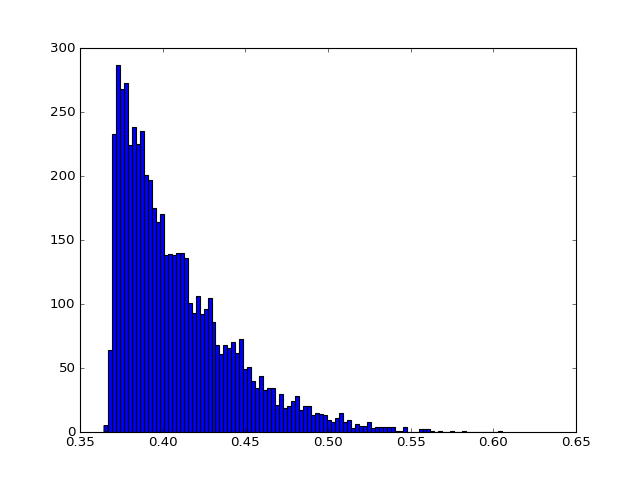

In [210]:
print np.where(frac_para_error>=0.3)[0].shape
print np.where(frac_para_error>=0.2)[0].shape
print frac_para_error[np.where(gdist>=2000)[0]]
%matplotlib notebook
plt.hist(frac_para_error[np.where(gdist>=2000)[0]],bins=100)
plt.show()

### Eliminate the >2000 pc sources:

In [211]:
print np.where(gdist>2000)[0].shape
print np.where(m['dist'].values>2000)[0].shape

(5637,)
(5637,)


In [212]:
n=m.drop(np.where(m['dist'].values>2000)[0],axis=0)
n=n.reset_index()
n = n.drop(['index'], axis=1)
n

solution_id                   designation  \
0       1635721458409799680  Gaia DR2 5853498713160606720   
1       1635721458409799680  Gaia DR2 1824801659879180544   
2       1635721458409799680  Gaia DR2 5978137354097288064   
3       1635721458409799680  Gaia DR2 4145394651996744704   
4       1635721458409799680  Gaia DR2 4090109764196360576   
5       1635721458409799680  Gaia DR2 4043588155928790528   
6       1635721458409799680  Gaia DR2 4046472106243728128   
7       1635721458409799680  Gaia DR2 4147859001074741888   
8       1635721458409799680  Gaia DR2 4049336059085668608   
9       1635721458409799680  Gaia DR2 4119879724447178624   
10      1635721458409799680  Gaia DR2 4050950657605998080   
11      1635721458409799680  Gaia DR2 4063051466107114496   
12      1635721458409799680  Gaia DR2 4038950244078680832   
13      1635721458409799680  Gaia DR2 4048896666737862656   
14      1635721458409799680  Gaia DR2 4048767474113708160   
15      1635721458409799680  Gaia DR2 2031625535133232768   
16      1635721458409799680  Gaia DR2 4089950541155819008   
17      1635721458409799680  Gaia DR2 4042723042164592128   
18      1635721458409799680  Gaia DR2 4118677756385143424   
19      1635721458409799680  Gaia DR2 4472832130942575872   
20      1635721458409799680  Gaia DR2 4117407579926310144   
21      1635721458409799680  Gaia DR2 4135193451742436864   
22      1635721458409799680  Gaia DR2 4077272484929328256   
23      1635721458409799680  Gaia DR2 4090344127699617920   
24      1635721458409799680  Gaia DR2 4064649198063448448   
25      1635721458409799680  Gaia DR2 4148058734300260224   
26      1635721458409799680  Gaia DR2 4307759121663604608   
27      1635721458409799680  Gaia DR2 4052244714083700352   
28      1635721458409799680  Gaia DR2 4147944694300162944   
29      1635721458409799680  Gaia DR2 4053037560744822016   
...                     ...                           ...   
841882  1635721458409799680  Gaia DR2 4090553584611941504   
841883  1635721458409799680  Gaia DR2 6058970670126598016   
841884  1635721458409799680  Gaia DR2 4145083936821049856   
841885  1635721458409799680  Gaia DR2 5986525292106292480   
841886  1635721458409799680  Gaia DR2 3630354642049110784   
841887  1635721458409799680  Gaia DR2 5950042396773144704   
841888  1635721458409799680  Gaia DR2 5865921540949980800   
841889  1635721458409799680  Gaia DR2 4758360663417267712   
841890  1635721458409799680  Gaia DR2 4236298592497310592   
841891  1635721458409799680  Gaia DR2 5254448391337136384   
841892  1635721458409799680  Gaia DR2 5782218508156944128   
841893  1635721458409799680  Gaia DR2 3027170744973947648   
841894  1635721458409799680  Gaia DR2 2018264647771334528   
841895  1635721458409799680  Gaia DR2 6110066246757712000   
841896  1635721458409799680  Gaia DR2 4116954100132046080   
841897  1635721458409799680  Gaia DR2 5819929145659779456   
841898  1635721458409799680  Gaia DR2 2339648735456227328   
841899  1635721458409799680  Gaia DR2 2025189234590060800   
841900  1635721458409799680  Gaia DR2 1833899156500646912   
841901  1635721458409799680  Gaia DR2 4113329899238104064   
841902  1635721458409799680  Gaia DR2 5714371493895176064   
841903  1635721458409799680  Gaia DR2 2177371539434689536   
841904  1635721458409799680  Gaia DR2 4092988384401360000   
841905  1635721458409799680  Gaia DR2 2047111778440125824   
841906  1635721458409799680  Gaia DR2 1827959079288949760   
841907  1635721458409799680  Gaia DR2 3938694918369774848   
841908  1635721458409799680  Gaia DR2 6784503380700679936   
841909  1635721458409799680  Gaia DR2 3062246368485918336   
841910  1635721458409799680  Gaia DR2 5877656147514690816   
841911  1635721458409799680  Gaia DR2 5339621990871151360   

                  source_id  random_index  ref_epoch          ra  ra_error  \
0       5853498713160606720     521085047     2015.5  217.393466  0.057653   
1       1824801659879180544    1636241798     2015.5  297.367581  1.605905   

Histogram of distances less than 2000 pc:

<IPython.core.display.Javascript object>


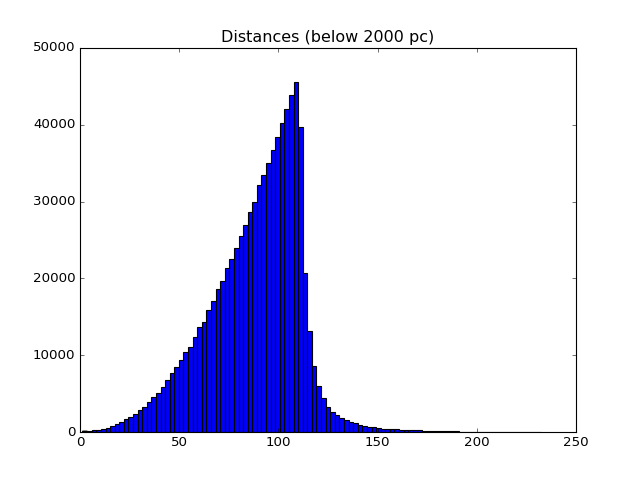

In [213]:
%matplotlib notebook
plt.hist(n['dist'],bins=100)
plt.title('Distances (below 2000 pc)')
plt.show()

In [192]:
print np.min(n['parallax'])

8.94966556929


## Get more to fill out to 1M:

In [193]:
start = time.time()
job = Gaia.launch_job_async(query="SELECT TOP 200000 * FROM gaiadr2.gaia_source WHERE parallax < 8.94966556929 \
                    ORDER BY parallax DESC",\
                    verbose=False, dump_to_file=True, output_format='csv')
print job

end = time.time()
print(end - start)

Jobid: 1530043616450O
Phase: COMPLETED
Owner: None
Output file: async_20180626130658.csv
Results: None
805.795394897


In [214]:
k = pd.read_csv('async_20180626130658.csv')

print np.where(np.isnan(k['bp_rp'].values))[0].shape

(29616,)


In [215]:
# Drop sources without G mag info:
m=k.drop(np.where(np.isnan(k['bp_rp'].values))[0],axis=0)
m=m.reset_index()
print np.where(np.isnan(m['bp_rp'].values))[0].shape
m = m.drop(['index'], axis=1)
m

(0,)


solution_id                   designation  \
0       1635721458409799680   Gaia DR2 334324446209239424   
1       1635721458409799680  Gaia DR2 1896348835665006592   
2       1635721458409799680   Gaia DR2 424353974423028224   
3       1635721458409799680  Gaia DR2 2887964257832593664   
4       1635721458409799680  Gaia DR2 5900131097216240640   
5       1635721458409799680  Gaia DR2 2047094632921795328   
6       1635721458409799680  Gaia DR2 4115482266271174784   
7       1635721458409799680  Gaia DR2 4169411421825200000   
8       1635721458409799680  Gaia DR2 2007278121428073472   
9       1635721458409799680  Gaia DR2 1760084680302323328   
10      1635721458409799680  Gaia DR2 6705360293216508544   
11      1635721458409799680  Gaia DR2 5620418392802604160   
12      1635721458409799680  Gaia DR2 2021973437958934016   
13      1635721458409799680  Gaia DR2 5965280528408485888   
14      1635721458409799680  Gaia DR2 5602411042345978880   
15      1635721458409799680  Gaia DR2 1916344524064828416   
16      1635721458409799680  Gaia DR2 5831155949668381440   
17      1635721458409799680  Gaia DR2 1906753930811629824   
18      1635721458409799680  Gaia DR2 4057912490272004992   
19      1635721458409799680  Gaia DR2 5619059538170428032   
20      1635721458409799680  Gaia DR2 4062950280788636416   
21      1635721458409799680  Gaia DR2 4923793359025058048   
22      1635721458409799680  Gaia DR2 4051152452277618304   
23      1635721458409799680  Gaia DR2 4612586690251472128   
24      1635721458409799680   Gaia DR2 495055527020429056   
25      1635721458409799680  Gaia DR2 2402226782620333824   
26      1635721458409799680  Gaia DR2 6061490647686516736   
27      1635721458409799680  Gaia DR2 4129168780850795008   
28      1635721458409799680  Gaia DR2 6822178284064238336   
29      1635721458409799680  Gaia DR2 1823858828622032512   
...                     ...                           ...   
170354  1635721458409799680  Gaia DR2 5867845450091099904   
170355  1635721458409799680  Gaia DR2 4563665230338892672   
170356  1635721458409799680  Gaia DR2 5890811121250797824   
170357  1635721458409799680  Gaia DR2 4061354099140761344   
170358  1635721458409799680  Gaia DR2 6109712440236769280   
170359  1635721458409799680  Gaia DR2 5861216391472386432   
170360  1635721458409799680  Gaia DR2 4571353462317943424   
170361  1635721458409799680  Gaia DR2 4090651097630959872   
170362  1635721458409799680  Gaia DR2 1343601628595846912   
170363  1635721458409799680  Gaia DR2 6316519792758658176   
170364  1635721458409799680  Gaia DR2 5979964123980850432   
170365  1635721458409799680  Gaia DR2 6665028110767806464   
170366  1635721458409799680  Gaia DR2 6436770557693525376   
170367  1635721458409799680  Gaia DR2 4283217506726062464   
170368  1635721458409799680  Gaia DR2 4507492108997490944   
170369  1635721458409799680  Gaia DR2 2861508324439755264   
170370  1635721458409799680  Gaia DR2 2090572964807856768   
170371  1635721458409799680  Gaia DR2 6679229020695536128   
170372  1635721458409799680  Gaia DR2 2018042134090633984   
170373  1635721458409799680  Gaia DR2 5340025305496860800   
170374  1635721458409799680  Gaia DR2 5961114715113311744   
170375  1635721458409799680   Gaia DR2 450266645986780032   
170376  1635721458409799680  Gaia DR2 4813489081216093568   
170377  1635721458409799680  Gaia DR2 1526943684992654976   
170378  1635721458409799680  Gaia DR2 2044079772024628480   
170379  1635721458409799680  Gaia DR2 6583262069572288768   
170380  1635721458409799680  Gaia DR2 6029816603938233344   
170381  1635721458409799680  Gaia DR2 5976868487618809984   
170382  1635721458409799680  Gaia DR2 6061964983926124032   
170383  1635721458409799680  Gaia DR2 4313272828914190208   

                  source_id  random_index  ref_epoch          ra  ra_error  \
0        334324446209239424     704175722     2015.5   40.496069  0.224063   
1       1896348835665006592    1639852432     2015.5  328.867562  0.345013   

In [216]:
# Compute distance:
gaia_id = m['source_id'].values
gra,gdec = m['ra'].values,m['dec'].values
gpmra,gpmde = m['pmra'].values,m['pmdec'].values
ggmag,gbpflux,grpflux = m['phot_g_mean_mag'].values,m['phot_bp_mean_flux'].values,m['phot_rp_mean_flux'].values
gbpmag,grpmag,gbprpmag = m['phot_bp_mean_mag'].values,m['phot_rp_mean_mag'].values,m['bp_rp'].values
gparallax,gparaerror = m['parallax'].values,m['parallax_error'].values
#l,b,ecl_lon,ecl_lat,radius,rv = k['l'].values,k['b'].values,k['ecl_lon'].values,k['ecl_lat'].values,\
#    k['radius_val'].values,k['radial_velocity'].values
#teff,lum,color = k['teff_val'].values,k['lum_val'].values,k['astrometric_pseudo_colour'].values

frac_para_error = gparaerror/gparallax
omega,sigma = gparallax/1000,gparaerror/1000

In [217]:
start = time.time()

omega,sigma = (gparallax+0.029)/1000,gparaerror/1000
gdist = np.array([])

print 'Computing distances'
count=0
for i in range(len(omega)):
    coeff = np.array([(1./L),(-2),((omega[i])/((sigma[i])**2)),-(1./((sigma[i])**2))])
    g = np.roots(coeff)
    # Find the number of real roots:
    reals = np.isreal(g)
    realsum = np.sum(reals)
    # If there is one real root, that root is the  mode:
    if realsum == 1:
        gd = np.real(g[np.where(reals)[0]])
    # If all roots are real:
    elif realsum == 3:
        if omega[i] >= 0:
            # Take the smallest root:
            gd = np.min(g)
        elif omega[i] < 0:
            # Take the positive root (there should be only one):
            gd = g[np.where(g>0)[0]]
    gdist = np.append(gdist,gd)
    
    count = count+1
    mod=count%50000
    if mod==0:
        print 'Finished ',count,' sources'
print 'Finished distances for ',gdist.shape[0]

end = time.time()
print(end - start)

print 'Computing FWHM'

count=0
rmax = 1e6
fwhm_lo,fwhm_hi = np.array([]),np.array([])
for i in range(len(omega)):
    rmode = gdist[i]
    M = (rmode**2*np.exp(-rmode/L)/sigma[i])*np.exp((-1./(2*(sigma[i])**2))*(omega[i]-(1./rmode))**2)
    lo = brentq(lambda x: 2*np.log(x)-(x/L)-(((omega[i]-(1./x))**2)/(2*sigma[i]**2)) \
               +np.log(2)-np.log(M)-np.log(sigma[i]), 0.001, rmode)
    hi = brentq(lambda x: 2*np.log(x)-(x/L)-(((omega[i]-(1./x))**2)/(2*sigma[i]**2)) \
               +np.log(2)-np.log(M)-np.log(sigma[i]), rmode, rmax)
    fwhm_lo,fwhm_hi = np.append(fwhm_lo,lo),np.append(fwhm_hi,hi)
    
    count = count+1
    mod=count%50000
    if mod==0:
        print 'Finished ',count,' sources'

print 'Finished FWHM for ',fwhm_lo.shape[0]
end = time.time()
print(end - start)

Computing distances
Finished  50000  sources
Finished  100000  sources
Finished  150000  sources
Finished distances for  170384
47.6253421307
Computing FWHM
Finished  50000  sources
Finished  100000  sources
Finished  150000  sources
Finished FWHM for  170384
169.178291082


In [219]:
# Make new columns in dataframe and populate with new data:
m['dist'],m['dist_fwhm_lo'],m['dist_fwhm_hi'] = pd.Series(gdist, index=m.index),\
    pd.Series(fwhm_lo, index=m.index),pd.Series(fwhm_hi, index=m.index)
m

solution_id                   designation  \
0       1635721458409799680   Gaia DR2 334324446209239424   
1       1635721458409799680  Gaia DR2 1896348835665006592   
2       1635721458409799680   Gaia DR2 424353974423028224   
3       1635721458409799680  Gaia DR2 2887964257832593664   
4       1635721458409799680  Gaia DR2 5900131097216240640   
5       1635721458409799680  Gaia DR2 2047094632921795328   
6       1635721458409799680  Gaia DR2 4115482266271174784   
7       1635721458409799680  Gaia DR2 4169411421825200000   
8       1635721458409799680  Gaia DR2 2007278121428073472   
9       1635721458409799680  Gaia DR2 1760084680302323328   
10      1635721458409799680  Gaia DR2 6705360293216508544   
11      1635721458409799680  Gaia DR2 5620418392802604160   
12      1635721458409799680  Gaia DR2 2021973437958934016   
13      1635721458409799680  Gaia DR2 5965280528408485888   
14      1635721458409799680  Gaia DR2 5602411042345978880   
15      1635721458409799680  Gaia DR2 1916344524064828416   
16      1635721458409799680  Gaia DR2 5831155949668381440   
17      1635721458409799680  Gaia DR2 1906753930811629824   
18      1635721458409799680  Gaia DR2 4057912490272004992   
19      1635721458409799680  Gaia DR2 5619059538170428032   
20      1635721458409799680  Gaia DR2 4062950280788636416   
21      1635721458409799680  Gaia DR2 4923793359025058048   
22      1635721458409799680  Gaia DR2 4051152452277618304   
23      1635721458409799680  Gaia DR2 4612586690251472128   
24      1635721458409799680   Gaia DR2 495055527020429056   
25      1635721458409799680  Gaia DR2 2402226782620333824   
26      1635721458409799680  Gaia DR2 6061490647686516736   
27      1635721458409799680  Gaia DR2 4129168780850795008   
28      1635721458409799680  Gaia DR2 6822178284064238336   
29      1635721458409799680  Gaia DR2 1823858828622032512   
...                     ...                           ...   
170354  1635721458409799680  Gaia DR2 5867845450091099904   
170355  1635721458409799680  Gaia DR2 4563665230338892672   
170356  1635721458409799680  Gaia DR2 5890811121250797824   
170357  1635721458409799680  Gaia DR2 4061354099140761344   
170358  1635721458409799680  Gaia DR2 6109712440236769280   
170359  1635721458409799680  Gaia DR2 5861216391472386432   
170360  1635721458409799680  Gaia DR2 4571353462317943424   
170361  1635721458409799680  Gaia DR2 4090651097630959872   
170362  1635721458409799680  Gaia DR2 1343601628595846912   
170363  1635721458409799680  Gaia DR2 6316519792758658176   
170364  1635721458409799680  Gaia DR2 5979964123980850432   
170365  1635721458409799680  Gaia DR2 6665028110767806464   
170366  1635721458409799680  Gaia DR2 6436770557693525376   
170367  1635721458409799680  Gaia DR2 4283217506726062464   
170368  1635721458409799680  Gaia DR2 4507492108997490944   
170369  1635721458409799680  Gaia DR2 2861508324439755264   
170370  1635721458409799680  Gaia DR2 2090572964807856768   
170371  1635721458409799680  Gaia DR2 6679229020695536128   
170372  1635721458409799680  Gaia DR2 2018042134090633984   
170373  1635721458409799680  Gaia DR2 5340025305496860800   
170374  1635721458409799680  Gaia DR2 5961114715113311744   
170375  1635721458409799680   Gaia DR2 450266645986780032   
170376  1635721458409799680  Gaia DR2 4813489081216093568   
170377  1635721458409799680  Gaia DR2 1526943684992654976   
170378  1635721458409799680  Gaia DR2 2044079772024628480   
170379  1635721458409799680  Gaia DR2 6583262069572288768   
170380  1635721458409799680  Gaia DR2 6029816603938233344   
170381  1635721458409799680  Gaia DR2 5976868487618809984   
170382  1635721458409799680  Gaia DR2 6061964983926124032   
170383  1635721458409799680  Gaia DR2 4313272828914190208   

                  source_id  random_index  ref_epoch          ra  ra_error  \
0        334324446209239424     704175722     2015.5   40.496069  0.224063   
1       1896348835665006592    1639852432     2015.5  328.867562  0.345013   

In [220]:
mm=m.drop(np.where(m['dist'].values>2000)[0],axis=0)
mm=mm.reset_index()
mm = mm.drop(['index'], axis=1)

### Put them together:

In [383]:
final = pd.concat([mm,n],ignore_index = True)
#final

In [384]:
# Add column for fractional parallax error:
# (Which is really just the inverse of the column "parallax_over_error")
gparallax,gparaerror = final['parallax'].values,final['parallax_error'].values
frac = gparaerror/gparallax
final['frac_para_error'] = pd.Series(frac, index=final.index)

# Sort by distance:
final = final.sort_values(by=['dist'])
final=final.reset_index()
final = final.drop(['index'], axis=1)
#final = final.drop(['level_0'], axis=1)

# Keep the top 1M results:
final = final.loc[:999999]

final

solution_id                   designation  \
0       1635721458409799680  Gaia DR2 5853498713160606720   
1       1635721458409799680  Gaia DR2 1824801659879180544   
2       1635721458409799680  Gaia DR2 5978137354097288064   
3       1635721458409799680  Gaia DR2 4145394651996744704   
4       1635721458409799680  Gaia DR2 4090109764196360576   
5       1635721458409799680  Gaia DR2 4043588155928790528   
6       1635721458409799680  Gaia DR2 4046472106243728128   
7       1635721458409799680  Gaia DR2 4147859001074741888   
8       1635721458409799680  Gaia DR2 4049336059085668608   
9       1635721458409799680  Gaia DR2 4119879724447178624   
10      1635721458409799680  Gaia DR2 4050950657605998080   
11      1635721458409799680  Gaia DR2 4063051466107114496   
12      1635721458409799680  Gaia DR2 4038950244078680832   
13      1635721458409799680  Gaia DR2 4048896666737862656   
14      1635721458409799680  Gaia DR2 4048767474113708160   
15      1635721458409799680  Gaia DR2 2031625535133232768   
16      1635721458409799680  Gaia DR2 4089950541155819008   
17      1635721458409799680  Gaia DR2 4042723042164592128   
18      1635721458409799680  Gaia DR2 4118677756385143424   
19      1635721458409799680  Gaia DR2 4472832130942575872   
20      1635721458409799680  Gaia DR2 4117407579926310144   
21      1635721458409799680  Gaia DR2 4135193451742436864   
22      1635721458409799680  Gaia DR2 4077272484929328256   
23      1635721458409799680  Gaia DR2 4090344127699617920   
24      1635721458409799680  Gaia DR2 4064649198063448448   
25      1635721458409799680  Gaia DR2 4148058734300260224   
26      1635721458409799680  Gaia DR2 4307759121663604608   
27      1635721458409799680  Gaia DR2 4052244714083700352   
28      1635721458409799680  Gaia DR2 4147944694300162944   
29      1635721458409799680  Gaia DR2 4053037560744822016   
...                     ...                           ...   
999970  1635721458409799680  Gaia DR2 1825887736831646208   
999971  1635721458409799680  Gaia DR2 6013928725305481216   
999972  1635721458409799680  Gaia DR2 1824074985774146048   
999973  1635721458409799680   Gaia DR2 263544970015750272   
999974  1635721458409799680  Gaia DR2 4370790000104736000   
999975  1635721458409799680  Gaia DR2 1829757055666265344   
999976  1635721458409799680  Gaia DR2 6805717289326436480   
999977  1635721458409799680  Gaia DR2 2862637690385525760   
999978  1635721458409799680  Gaia DR2 5828253204584556160   
999979  1635721458409799680  Gaia DR2 6075023230637551104   
999980  1635721458409799680  Gaia DR2 6753793123288330368   
999981  1635721458409799680  Gaia DR2 2076462073089089280   
999982  1635721458409799680   Gaia DR2 208061684838304128   
999983  1635721458409799680  Gaia DR2 2201199811841095040   
999984  1635721458409799680  Gaia DR2 2138482294198364800   
999985  1635721458409799680  Gaia DR2 4661445207533989376   
999986  1635721458409799680  Gaia DR2 5445573061617571072   
999987  1635721458409799680  Gaia DR2 4070660537410386048   
999988  1635721458409799680  Gaia DR2 5933011270943027456   
999989  1635721458409799680  Gaia DR2 5993709707217780480   
999990  1635721458409799680  Gaia DR2 5715315149751529344   
999991  1635721458409799680  Gaia DR2 4467570903366037120   
999992  1635721458409799680  Gaia DR2 6059477132652515584   
999993  1635721458409799680  Gaia DR2 4138792874851654784   
999994  1635721458409799680   Gaia DR2 771823524515859072   
999995  1635721458409799680  Gaia DR2 6197727628782525440   
999996  1635721458409799680  Gaia DR2 5309036154371280256   
999997  1635721458409799680  Gaia DR2 6074871463675251200   
999998  1635721458409799680  Gaia DR2 4318011758394316800   
999999  1635721458409799680  Gaia DR2 4138274966215835392   

                  source_id  random_index  ref_epoch          ra  ra_error  \
0       5853498713160606720     521085047     2015.5  217.393466  0.057653   
1       1824801659879180544    1636241798     2015.5  297.367581  1.605905   

In [ ]:
# Write it out!
final.to_csv('Nearest_1M_stars.csv')

In [7]:
final = pd.read_csv('Nearest_1M_stars.csv')
final

Unnamed: 0          solution_id                   designation  \
0                0  1635721458409799680  Gaia DR2 5853498713160606720   
1                1  1635721458409799680  Gaia DR2 1824801659879180544   
2                2  1635721458409799680  Gaia DR2 5978137354097288064   
3                3  1635721458409799680  Gaia DR2 4145394651996744704   
4                4  1635721458409799680  Gaia DR2 4090109764196360576   
5                5  1635721458409799680  Gaia DR2 4043588155928790528   
6                6  1635721458409799680  Gaia DR2 4046472106243728128   
7                7  1635721458409799680  Gaia DR2 4147859001074741888   
8                8  1635721458409799680  Gaia DR2 4049336059085668608   
9                9  1635721458409799680  Gaia DR2 4119879724447178624   
10              10  1635721458409799680  Gaia DR2 4050950657605998080   
11              11  1635721458409799680  Gaia DR2 4063051466107114496   
12              12  1635721458409799680  Gaia DR2 4038950244078680832   
13              13  1635721458409799680  Gaia DR2 4048896666737862656   
14              14  1635721458409799680  Gaia DR2 4048767474113708160   
15              15  1635721458409799680  Gaia DR2 2031625535133232768   
16              16  1635721458409799680  Gaia DR2 4089950541155819008   
17              17  1635721458409799680  Gaia DR2 4042723042164592128   
18              18  1635721458409799680  Gaia DR2 4118677756385143424   
19              19  1635721458409799680  Gaia DR2 4472832130942575872   
20              20  1635721458409799680  Gaia DR2 4117407579926310144   
21              21  1635721458409799680  Gaia DR2 4135193451742436864   
22              22  1635721458409799680  Gaia DR2 4077272484929328256   
23              23  1635721458409799680  Gaia DR2 4090344127699617920   
24              24  1635721458409799680  Gaia DR2 4064649198063448448   
25              25  1635721458409799680  Gaia DR2 4148058734300260224   
26              26  1635721458409799680  Gaia DR2 4307759121663604608   
27              27  1635721458409799680  Gaia DR2 4052244714083700352   
28              28  1635721458409799680  Gaia DR2 4147944694300162944   
29              29  1635721458409799680  Gaia DR2 4053037560744822016   
...            ...                  ...                           ...   
999970      999970  1635721458409799680  Gaia DR2 1825887736831646208   
999971      999971  1635721458409799680  Gaia DR2 6013928725305481216   
999972      999972  1635721458409799680  Gaia DR2 1824074985774146048   
999973      999973  1635721458409799680   Gaia DR2 263544970015750272   
999974      999974  1635721458409799680  Gaia DR2 4370790000104736000   
999975      999975  1635721458409799680  Gaia DR2 1829757055666265344   
999976      999976  1635721458409799680  Gaia DR2 6805717289326436480   
999977      999977  1635721458409799680  Gaia DR2 2862637690385525760   
999978      999978  1635721458409799680  Gaia DR2 5828253204584556160   
999979      999979  1635721458409799680  Gaia DR2 6075023230637551104   
999980      999980  1635721458409799680  Gaia DR2 6753793123288330368   
999981      999981  1635721458409799680  Gaia DR2 2076462073089089280   
999982      999982  1635721458409799680   Gaia DR2 208061684838304128   
999983      999983  1635721458409799680  Gaia DR2 2201199811841095040   
999984      999984  1635721458409799680  Gaia DR2 2138482294198364800   
999985      999985  1635721458409799680  Gaia DR2 4661445207533989376   
999986      999986  1635721458409799680  Gaia DR2 5445573061617571072   
999987      999987  1635721458409799680  Gaia DR2 4070660537410386048   
999988      999988  1635721458409799680  Gaia DR2 5933011270943027456   
999989      999989  1635721458409799680  Gaia DR2 5993709707217780480   
999990      999990  1635721458409799680  Gaia DR2 5715315149751529344   
999991      999991  1635721458409799680  Gaia DR2 4467570903366037120   
999992      999992  1635721458409799680  Gaia DR2 6059477132652515

### Compute uncertainty on the distance.

As demonstrated elsewhere, for sources with f <~ 0.1, you can approximate the poterior distance distribution as gaussian, so we can use sigma=FWHM/2.355 to approximate the std dev.  This means the 95% CI is ~ +/- 2*sigma

For f larger than 0.1, the 95% CI has to be estimated with an MCMC.  Which is computationalls intensive.  In this sample, ~380,000 sources have f>.1:

In [8]:
print np.where(final['frac_para_error']<0.1)[0].shape
print np.where(final['frac_para_error']>0.1)[0]


(618209,)
[  4643   7075   7626 ..., 999997 999998 999999]


In [9]:
print np.where(final['frac_para_error']<0.10)[0].shape
ind = np.where(final['frac_para_error']<0.10)[0]
print ind
ddist = final['dist'].values[ind]
ddist_sigma = (final['dist_fwhm_hi'].values[ind]-final['dist_fwhm_lo'].values[ind])/2.355
dist_95ci_lo = ddist-2*ddist_sigma
dist_95ci_hi = ddist+2*ddist_sigma
print dist_95ci_lo.shape
count=0


(618209,)
[     0      1      2 ..., 926523 926775 926806]
(618209,)


In [10]:
#q = pd.DataFrame(data=[ind[:],dist_95ci_lo[:],dist_95ci_hi[:]],    # values
#                  index=ind,    
#                  columns=['index','dist_95ci_lo','dist_95ci_hi'])
q = pd.DataFrame({'index': ind,
                  'dist_95ci_lo.q': dist_95ci_lo,
                  'dist_95ci_hi.q': dist_95ci_hi},
                 index=ind)
q

dist_95ci_hi.q  dist_95ci_lo.q   index
0             1.301874        1.300499       0
1             1.362156        1.343137       1
2             1.491485        1.470948       2
3             1.493711        1.469500       3
4             1.500263        1.474078       4
5             1.529251        1.519345       5
6             1.538214        1.512343       6
7             1.539672        1.524414       7
8             1.545184        1.528568       8
9             1.553298        1.528544       9
10            1.569657        1.554488      10
11            1.574747        1.561607      11
12            1.590488        1.573473      12
13            1.597814        1.584835      13
14            1.603370        1.582231      14
15            1.629712        1.602824      15
16            1.645584        1.624589      16
17            1.661992        1.638157      17
18            1.745692        1.732596      18
19            1.828487        1.824619      19
20            1.898283        1.856673      20
21            1.934975        1.897794      21
22            1.935417        1.901419      22
23            2.019494        1.978760      23
24            2.028080        2.002857      24
25            2.054894        1.992676      25
26            2.052165        2.017097      26
27            2.057426        2.041183      27
28            2.082544        2.055943      28
29            2.092749        2.074595      29
...                ...             ...     ...
925134      144.944332       95.164482  925134
925152      144.071531       96.040668  925152
925203      144.566123       95.555521  925203
925234      144.808597       95.317812  925234
925245      144.430026       95.699513  925245
925345      144.355440       95.795278  925345
925377      144.765658       95.392637  925377
925378      144.544569       95.613729  925378
925442      144.340105       95.827125  925442
925460      144.698309       95.472265  925460
925471      144.296307       95.876573  925471
925509      144.833840       95.347156  925509
925699      144.680789       95.540020  925699
925703      144.823799       95.398145  925703
925712      144.833301       95.390523  925712
925783      144.678411       95.560135  925783
925797      145.015052       95.226130  925797
925818      145.125316       95.119247  925818
925935      144.997635       95.274415  925935
926026      144.732581       95.558467  926026
926090      145.084653       95.218117  926090
926098      144.981610       95.322186  926098
926111      145.109363       95.197202  926111
926202      145.050344       95.274701  926202
926219      144.839879       95.487816  926219
926253      144.833649       95.500658  926253
926415      145.039912       95.326652  926415
926523      145.126605       95.259466  926523
926775      145.145902       95.286492  926775
926806      145.210317       95.228564  926806

[618209 rows x 3 columns]

#### MCMC time

What to do with sources with f>0.1.  That's about 380,000 sources of the 1M.

In [12]:
def prob(r,omega,sigma):
    p = (r**2*np.exp(-r/L)/(sigma))*np.exp((-1/(2*(sigma)**2))*(omega-(1/r))**2)
    if not np.isfinite(p):
        return -np.inf 
    return p

def sampler(lnprob,mu_init=0,omega=0,sigma=0,proposal_width=0.5,nsamples=50,prob=[0.05, 0.5, 0.95]):
    mu_current = mu_init
    posterior = [mu_current]
    yes_accept = 0
    for i in range(nsamples):
        mu_proposal = norm(mu_current,proposal_width).rvs()
        prob_of_proposal = lnprob(mu_proposal,omega,sigma)
        prob_current = lnprob(mu_current,omega,sigma)
        p_accept = prob_of_proposal/prob_current
        dice = np.random.rand()
        accept = dice < p_accept
        if accept:
            mu_current = mu_proposal
            yes_accept = yes_accept+1 #for tracking acceptance rate
        posterior.append(mu_current)
    return posterior,mquantiles(posterior, prob=prob),np.float(yes_accept)/np.float(nsamples)


In [ ]:
# Pull out relevant rows: All sources with f>0.1
ind = np.where(final['frac_para_error']>0.10)[0]
mu_init,om,sig = final['dist'].values[ind],final['parallax'].values[ind],final['parallax_error'].values[ind]
posterior,dist_95ci_lo,dist_95ci_hi = np.zeros(len(mu_init)),np.zeros(len(mu_init)),np.zeros(len(mu_init))
count = 0
#run mcmc !Warning takes a loooooong time!
for i in ind:
    post,quant,accept_rate = sampler(prob,mu_init=mu_init[i],omega=om[i],sigma=sig[i],nsamples=7000,proposal_width=1.0)
    

This next bit is because my MCMC TACC solution below had a tiny bug which cause it to not compute the last ~45 sources.  So I did it here quickly and shoved it on the end of the FWHM estimator dataframe.  If you want you can pretend this part doesn't exist.  (Basically the bug is because the script I wrote that worked nicely on my computer didn't work the same way on the TACC computer and I came up with a bandaid.)

In [14]:
ind = np.arange(999953,1000000,1)
mu_init,om,sig = final['dist'].values[ind],final['parallax'].values[ind],final['parallax_error'].values[ind]
posterior,dist_95ci_lo2,dist_95ci_hi2 = np.array([]),np.array([]),np.array([])
count = 0
L=1350

#print mu_init

for i in range(len(ind)):
    count=count+1
    post,quant,accept_rate = sampler(prob,mu_init=mu_init[i],omega=om[i],sigma=sig[i],nsamples=7000,proposal_width=1.0)
    dist_95ci_lo2,dist_95ci_hi2 = np.append(dist_95ci_lo2,quant[0]),np.append(dist_95ci_hi2,quant[2])
    mod=count%10
    if mod==0:
        print count
print dist_95ci_lo2

10
20
30
40
[ 140.07133444  153.09417286  129.88331184  157.28865438   82.88739696
  170.64239031  174.8457467   138.16452151  163.06731273   53.87991084
  125.3261574   117.40361459  159.00895682  112.64984869  165.99093015
  162.26446589  162.33259829   75.27185306  121.85178336  124.55132512
  147.81937436  131.05774004  123.93638645   58.61952106  164.49105965
   39.91950295   85.3677295   119.79618622  159.42371421   70.43082278
  143.99890129  137.47050234  133.24654034  113.99384064  100.35450644
   87.79227265   54.32924908  104.25486594   84.61623066  159.74310861
  106.08038331  144.1953438   105.04549617  118.31784912  139.03875763
   82.90377946  118.36346201]


In [15]:
ind = np.arange(999953,1000000,1)
q2 = pd.DataFrame({'index': ind,
                  'dist_95ci_lo.q': dist_95ci_lo2,
                  'dist_95ci_hi.q': dist_95ci_hi2},
                 index=ind)
q3 = q.append(q2,ignore_index=False,sort=False)
q3

dist_95ci_hi.q  dist_95ci_lo.q   index
0             1.301874        1.300499       0
1             1.362156        1.343137       1
2             1.491485        1.470948       2
3             1.493711        1.469500       3
4             1.500263        1.474078       4
5             1.529251        1.519345       5
6             1.538214        1.512343       6
7             1.539672        1.524414       7
8             1.545184        1.528568       8
9             1.553298        1.528544       9
10            1.569657        1.554488      10
11            1.574747        1.561607      11
12            1.590488        1.573473      12
13            1.597814        1.584835      13
14            1.603370        1.582231      14
15            1.629712        1.602824      15
16            1.645584        1.624589      16
17            1.661992        1.638157      17
18            1.745692        1.732596      18
19            1.828487        1.824619      19
20            1.898283        1.856673      20
21            1.934975        1.897794      21
22            1.935417        1.901419      22
23            2.019494        1.978760      23
24            2.028080        2.002857      24
25            2.054894        1.992676      25
26            2.052165        2.017097      26
27            2.057426        2.041183      27
28            2.082544        2.055943      28
29            2.092749        2.074595      29
...                ...             ...     ...
999970      201.572856       75.271853  999970
999971      255.855504      121.851783  999971
999972      214.345912      124.551325  999972
999973      204.034327      147.819374  999973
999974      198.115345      131.057740  999974
999975      234.157499      123.936386  999975
999976      163.653890       58.619521  999976
999977      285.073360      164.491060  999977
999978      135.101660       39.919503  999978
999979      166.398681       85.367729  999979
999980      210.068048      119.796186  999980
999981      308.649600      159.423714  999981
999982      187.039874       70.430823  999982
999983      311.469407      143.998901  999983
999984      263.134650      137.470502  999984
999985      262.276378      133.246540  999985
999986      193.171976      113.993841  999986
999987      187.298901      100.354506  999987
999988      145.174654       87.792273  999988
999989      166.837989       54.329249  999989
999990      156.917476      104.254866  999990
999991      158.917238       84.616231  999991
999992      466.751743      159.743109  999992
999993      211.090047      106.080383  999993
999994      254.618035      144.195344  999994
999995      237.113217      105.045496  999995
999996      177.634335      118.317849  999996
999997      224.012520      139.038758  999997
999998      153.552423       82.903779  999998
999999      207.442416      118.363462  999999

[618256 rows x 3 columns]

In [16]:
master = pd.concat([final,q3['dist_95ci_lo.q'],q3['dist_95ci_hi.q'],q3['index']],ignore_index = False,axis=1,sort=False)
#pp = pd.merge(final, p['dist_95ci_lo'], on=['index'])
master

Unnamed: 0          solution_id                   designation  \
0                0  1635721458409799680  Gaia DR2 5853498713160606720   
1                1  1635721458409799680  Gaia DR2 1824801659879180544   
2                2  1635721458409799680  Gaia DR2 5978137354097288064   
3                3  1635721458409799680  Gaia DR2 4145394651996744704   
4                4  1635721458409799680  Gaia DR2 4090109764196360576   
5                5  1635721458409799680  Gaia DR2 4043588155928790528   
6                6  1635721458409799680  Gaia DR2 4046472106243728128   
7                7  1635721458409799680  Gaia DR2 4147859001074741888   
8                8  1635721458409799680  Gaia DR2 4049336059085668608   
9                9  1635721458409799680  Gaia DR2 4119879724447178624   
10              10  1635721458409799680  Gaia DR2 4050950657605998080   
11              11  1635721458409799680  Gaia DR2 4063051466107114496   
12              12  1635721458409799680  Gaia DR2 4038950244078680832   
13              13  1635721458409799680  Gaia DR2 4048896666737862656   
14              14  1635721458409799680  Gaia DR2 4048767474113708160   
15              15  1635721458409799680  Gaia DR2 2031625535133232768   
16              16  1635721458409799680  Gaia DR2 4089950541155819008   
17              17  1635721458409799680  Gaia DR2 4042723042164592128   
18              18  1635721458409799680  Gaia DR2 4118677756385143424   
19              19  1635721458409799680  Gaia DR2 4472832130942575872   
20              20  1635721458409799680  Gaia DR2 4117407579926310144   
21              21  1635721458409799680  Gaia DR2 4135193451742436864   
22              22  1635721458409799680  Gaia DR2 4077272484929328256   
23              23  1635721458409799680  Gaia DR2 4090344127699617920   
24              24  1635721458409799680  Gaia DR2 4064649198063448448   
25              25  1635721458409799680  Gaia DR2 4148058734300260224   
26              26  1635721458409799680  Gaia DR2 4307759121663604608   
27              27  1635721458409799680  Gaia DR2 4052244714083700352   
28              28  1635721458409799680  Gaia DR2 4147944694300162944   
29              29  1635721458409799680  Gaia DR2 4053037560744822016   
...            ...                  ...                           ...   
999970      999970  1635721458409799680  Gaia DR2 1825887736831646208   
999971      999971  1635721458409799680  Gaia DR2 6013928725305481216   
999972      999972  1635721458409799680  Gaia DR2 1824074985774146048   
999973      999973  1635721458409799680   Gaia DR2 263544970015750272   
999974      999974  1635721458409799680  Gaia DR2 4370790000104736000   
999975      999975  1635721458409799680  Gaia DR2 1829757055666265344   
999976      999976  1635721458409799680  Gaia DR2 6805717289326436480   
999977      999977  1635721458409799680  Gaia DR2 2862637690385525760   
999978      999978  1635721458409799680  Gaia DR2 5828253204584556160   
999979      999979  1635721458409799680  Gaia DR2 6075023230637551104   
999980      999980  1635721458409799680  Gaia DR2 6753793123288330368   
999981      999981  1635721458409799680  Gaia DR2 2076462073089089280   
999982      999982  1635721458409799680   Gaia DR2 208061684838304128   
999983      999983  1635721458409799680  Gaia DR2 2201199811841095040   
999984      999984  1635721458409799680  Gaia DR2 2138482294198364800   
999985      999985  1635721458409799680  Gaia DR2 4661445207533989376   
999986      999986  1635721458409799680  Gaia DR2 5445573061617571072   
999987      999987  1635721458409799680  Gaia DR2 4070660537410386048   
999988      999988  1635721458409799680  Gaia DR2 5933011270943027456   
999989      999989  1635721458409799680  Gaia DR2 5993709707217780480   
999990      999990  1635721458409799680  Gaia DR2 5715315149751529344   
999991      999991  1635721458409799680  Gaia DR2 4467570903366037120   
999992      999992  1635721458409799680  Gaia DR2 6059477132652515

### A better way.

So I could execute this cell this way.  To get 10,000 samples takes about 5-10 s per source.  Times 380,000 sources, that is 527 hours.  Unmanageable.  A better way is to use paralla processing.

I wrote a parallel process code called "gaia_distance_error_mcmc.py".  It splits up the source list and divides the tasks among the processor cores.  Each core only gets a chunk of the list to run the mcmc on.  I have some time on the Texas Advanced Computing Center (TACC) supercomputer Lonestar 5, which has 48 cores.  380,000/48 with 5 seconds per run takes about 11 hours.  Totally doable!

Make a new dataframe of just the sources with f>0.1 and write out to csv:

In [54]:
out = final.filter(['parallax','parallax_error','dist'], axis=1)
out = out.loc[ind]
out['index'] = pd.Series(ind, index=out.index)
out.to_csv('input_to_mcmc.csv')
#out

#### Demonstration of f=0.1 cut:

In [62]:
print np.where(np.round(final['frac_para_error'].values,decimals=3)==0.05)
print final['frac_para_error'].values[1906]

(array([  1602,   1831,   1906, ..., 905112, 905766, 907102]),)
0.0501488729812


4.62596210957 30.5809882948 34.292441161
0.151269215533
2 sigma of gaussian approx 5.8013510896


<IPython.core.display.Javascript object>


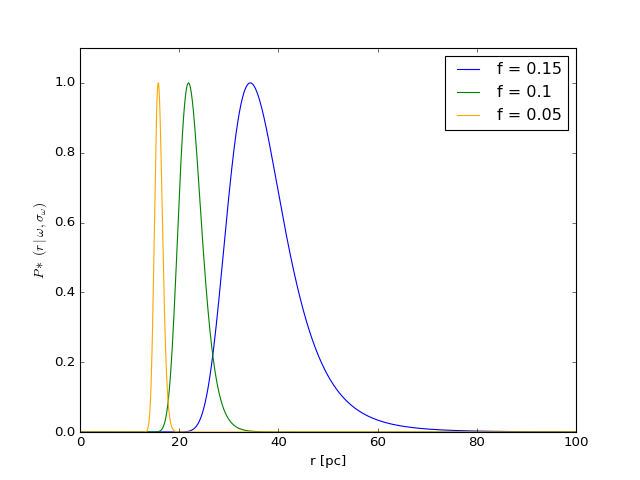

In [65]:
print final['parallax_error'].values[17712],final['parallax'].values[17712],final['dist'].values[17712]
print final['parallax_error'].values[17712]/final['parallax'].values[17712]
print '2 sigma of gaussian approx',(final['dist_fwhm_hi'].values[17712]-final['dist_fwhm_lo'].values[17712])/2.355
twosigma = (final['dist_fwhm_hi'].values[17712]-final['dist_fwhm_lo'].values[17712])/2.355
twosigma2 = (final['dist_fwhm_hi'].values[4643]-final['dist_fwhm_lo'].values[4643])/2.355
L=1350
r = np.linspace(0,100,1e3-1)

post = (r**2*np.exp(-r/L)/final['parallax_error'].values[4643]/1000)*\
    np.exp((-1/(2*(final['parallax_error'].values[17712]/1000)**2))*(final['parallax'].values[17712]/1000-(1/r))**2)
post2 = (r**2*np.exp(-r/L)/final['parallax_error'].values[4643]/1000)*\
    np.exp((-1/(2*(final['parallax_error'].values[4643]/1000)**2))*(final['parallax'].values[4643]/1000-(1/r))**2)
post3 = (r**2*np.exp(-r/L)/final['parallax_error'].values[1906]/1000)*\
    np.exp((-1/(2*(final['parallax_error'].values[1906]/1000)**2))*(final['parallax'].values[1906]/1000-(1/r))**2)

%matplotlib notebook
plt.plot(r,post/np.max(post),label='f = {0}'.format(0.15))
plt.plot(r,post2/np.max(post2),label='f = {0}'.format(0.1),color='green')
plt.plot(r,post3/np.max(post3),label='f = {0}'.format(0.05),color='orange')
#plt.axvline(x=28.4)
#plt.axvline(x=46.688)
#plt.axvline(x=19.02,color='green')
#plt.axvline(x=27.858,color='green')
#plt.axvline(x=final['dist'].values[17712]+twosigma,color='red')
#plt.axvline(x=final['dist'].values[17712]-twosigma,color='red')
#plt.axvline(x=final['dist'].values[4643]+twosigma,color='orange')
#plt.axvline(x=final['dist'].values[4643]-twosigma,color='orange')
#plt.annotate('red line is 2*sigma, blue and green lines \nare mcmc 95% quantiles.  f=0.15 is \nalready too skewed to be\
#    \napproximated as gaussian.',xy=(50,0.4),xytext=(50,0.4))
plt.ylim(0,1.1)
plt.legend()
plt.ylabel('$P*\;(r \mid \omega , \sigma_{\omega})$')
plt.xlabel('r [pc]')
plt.show()

### Read in the MCMC TACC output:

In [19]:
from astropy.table import Table
print np.where(final['frac_para_error']>0.1)[0].shape
print 'Each process should have :',np.int_(float(np.where(final['frac_para_error']>0.1)[0].shape[0])/48.),' solutions'
finalarray = np.loadtxt('0_finalarray_mpi.csv',delimiter=',',skiprows=1)
print finalarray.shape

for i in range(1,48):
    a = np.loadtxt(str(i)+'_finalarray_mpi.csv',delimiter=',',skiprows=1)
    finalarray = np.vstack ([finalarray,a])
print finalarray.shape
t = Table([finalarray[:,0], finalarray[:,1], finalarray[:,2], finalarray[:,3], finalarray[:,4], finalarray[:,5], finalarray[:,6]], \
                  names=('index', 'dist', 'parallax','para_sigma', 'quant_lo', 'quant_median', 'quant_hi'))
t.write('final_mcmc_output.csv', format='csv',overwrite=True)

(381791,)
Each process should have : 7953  solutions
(7953, 7)
(381744, 7)


In [20]:
columns=['index.p','dist','parallax','para_sigma','dist_95ci_lo.p','quant_median','dist_95ci_hi.p']
p = pd.DataFrame(data=finalarray[1:,0:],    # values
                  index=np.int_(finalarray[1:,0]),    # 1st column as index
                  columns=columns)
#p

### Put them together:

In [21]:
# Let's check that everything makes sense.  Location 999952 was computed via MCMC, so it should be a nan in the master
# array (which for right now is just the FWHM computes), and have values on the p array (which is the 
# MCMC computes):
print master.loc[999952,'dist_95ci_lo.q'],master.loc[999952,'dist_95ci_hi.q']
print p.loc[999952,'dist_95ci_lo.p'],p.loc[999952,'dist_95ci_hi.p']

nan nan
69.5555409812 154.515151047


Now combine the two 95% CI method columns by smooshing them together using "fillna" to fill in nans in the master dataframe with values from the p dataframe:

In [22]:
# Smoosh them:
pp_lo = master['dist_95ci_lo.q'].fillna(p['dist_95ci_lo.p'])
pp_hi = master['dist_95ci_hi.q'].fillna(p['dist_95ci_hi.p'])
print pp_lo.loc[999952],pp_hi.loc[999952]

# Make a new column on the master dataframe to hold the new complete 95% CI columns:
master['dist_95ci_lo'] = pp_lo
master['dist_95ci_hi'] = pp_hi
master

69.5555409812 154.515151047


Unnamed: 0          solution_id                   designation  \
0                0  1635721458409799680  Gaia DR2 5853498713160606720   
1                1  1635721458409799680  Gaia DR2 1824801659879180544   
2                2  1635721458409799680  Gaia DR2 5978137354097288064   
3                3  1635721458409799680  Gaia DR2 4145394651996744704   
4                4  1635721458409799680  Gaia DR2 4090109764196360576   
5                5  1635721458409799680  Gaia DR2 4043588155928790528   
6                6  1635721458409799680  Gaia DR2 4046472106243728128   
7                7  1635721458409799680  Gaia DR2 4147859001074741888   
8                8  1635721458409799680  Gaia DR2 4049336059085668608   
9                9  1635721458409799680  Gaia DR2 4119879724447178624   
10              10  1635721458409799680  Gaia DR2 4050950657605998080   
11              11  1635721458409799680  Gaia DR2 4063051466107114496   
12              12  1635721458409799680  Gaia DR2 4038950244078680832   
13              13  1635721458409799680  Gaia DR2 4048896666737862656   
14              14  1635721458409799680  Gaia DR2 4048767474113708160   
15              15  1635721458409799680  Gaia DR2 2031625535133232768   
16              16  1635721458409799680  Gaia DR2 4089950541155819008   
17              17  1635721458409799680  Gaia DR2 4042723042164592128   
18              18  1635721458409799680  Gaia DR2 4118677756385143424   
19              19  1635721458409799680  Gaia DR2 4472832130942575872   
20              20  1635721458409799680  Gaia DR2 4117407579926310144   
21              21  1635721458409799680  Gaia DR2 4135193451742436864   
22              22  1635721458409799680  Gaia DR2 4077272484929328256   
23              23  1635721458409799680  Gaia DR2 4090344127699617920   
24              24  1635721458409799680  Gaia DR2 4064649198063448448   
25              25  1635721458409799680  Gaia DR2 4148058734300260224   
26              26  1635721458409799680  Gaia DR2 4307759121663604608   
27              27  1635721458409799680  Gaia DR2 4052244714083700352   
28              28  1635721458409799680  Gaia DR2 4147944694300162944   
29              29  1635721458409799680  Gaia DR2 4053037560744822016   
...            ...                  ...                           ...   
999970      999970  1635721458409799680  Gaia DR2 1825887736831646208   
999971      999971  1635721458409799680  Gaia DR2 6013928725305481216   
999972      999972  1635721458409799680  Gaia DR2 1824074985774146048   
999973      999973  1635721458409799680   Gaia DR2 263544970015750272   
999974      999974  1635721458409799680  Gaia DR2 4370790000104736000   
999975      999975  1635721458409799680  Gaia DR2 1829757055666265344   
999976      999976  1635721458409799680  Gaia DR2 6805717289326436480   
999977      999977  1635721458409799680  Gaia DR2 2862637690385525760   
999978      999978  1635721458409799680  Gaia DR2 5828253204584556160   
999979      999979  1635721458409799680  Gaia DR2 6075023230637551104   
999980      999980  1635721458409799680  Gaia DR2 6753793123288330368   
999981      999981  1635721458409799680  Gaia DR2 2076462073089089280   
999982      999982  1635721458409799680   Gaia DR2 208061684838304128   
999983      999983  1635721458409799680  Gaia DR2 2201199811841095040   
999984      999984  1635721458409799680  Gaia DR2 2138482294198364800   
999985      999985  1635721458409799680  Gaia DR2 4661445207533989376   
999986      999986  1635721458409799680  Gaia DR2 5445573061617571072   
999987      999987  1635721458409799680  Gaia DR2 4070660537410386048   
999988      999988  1635721458409799680  Gaia DR2 5933011270943027456   
999989      999989  1635721458409799680  Gaia DR2 5993709707217780480   
999990      999990  1635721458409799680  Gaia DR2 5715315149751529344   
999991      999991  1635721458409799680  Gaia DR2 4467570903366037120   
999992      999992  1635721458409799680  Gaia DR2 6059477132652515

In [23]:
# Let's check that 999952 on the master frame is now filled with the mcmc values in the new finished columns:
print master.loc[999952,'dist_95ci_lo'],master.loc[999952,'dist_95ci_hi']
print p.loc[999952,'dist_95ci_lo.p'],p.loc[999952,'dist_95ci_hi.p']

69.5555409812 154.515151047
69.5555409812 154.515151047


In [24]:
# Looks good.  Let's delete the extraneous columns now:
final = master.drop(['dist_95ci_lo.q','dist_95ci_hi.q','index'],axis=1)
final

Unnamed: 0          solution_id                   designation  \
0                0  1635721458409799680  Gaia DR2 5853498713160606720   
1                1  1635721458409799680  Gaia DR2 1824801659879180544   
2                2  1635721458409799680  Gaia DR2 5978137354097288064   
3                3  1635721458409799680  Gaia DR2 4145394651996744704   
4                4  1635721458409799680  Gaia DR2 4090109764196360576   
5                5  1635721458409799680  Gaia DR2 4043588155928790528   
6                6  1635721458409799680  Gaia DR2 4046472106243728128   
7                7  1635721458409799680  Gaia DR2 4147859001074741888   
8                8  1635721458409799680  Gaia DR2 4049336059085668608   
9                9  1635721458409799680  Gaia DR2 4119879724447178624   
10              10  1635721458409799680  Gaia DR2 4050950657605998080   
11              11  1635721458409799680  Gaia DR2 4063051466107114496   
12              12  1635721458409799680  Gaia DR2 4038950244078680832   
13              13  1635721458409799680  Gaia DR2 4048896666737862656   
14              14  1635721458409799680  Gaia DR2 4048767474113708160   
15              15  1635721458409799680  Gaia DR2 2031625535133232768   
16              16  1635721458409799680  Gaia DR2 4089950541155819008   
17              17  1635721458409799680  Gaia DR2 4042723042164592128   
18              18  1635721458409799680  Gaia DR2 4118677756385143424   
19              19  1635721458409799680  Gaia DR2 4472832130942575872   
20              20  1635721458409799680  Gaia DR2 4117407579926310144   
21              21  1635721458409799680  Gaia DR2 4135193451742436864   
22              22  1635721458409799680  Gaia DR2 4077272484929328256   
23              23  1635721458409799680  Gaia DR2 4090344127699617920   
24              24  1635721458409799680  Gaia DR2 4064649198063448448   
25              25  1635721458409799680  Gaia DR2 4148058734300260224   
26              26  1635721458409799680  Gaia DR2 4307759121663604608   
27              27  1635721458409799680  Gaia DR2 4052244714083700352   
28              28  1635721458409799680  Gaia DR2 4147944694300162944   
29              29  1635721458409799680  Gaia DR2 4053037560744822016   
...            ...                  ...                           ...   
999970      999970  1635721458409799680  Gaia DR2 1825887736831646208   
999971      999971  1635721458409799680  Gaia DR2 6013928725305481216   
999972      999972  1635721458409799680  Gaia DR2 1824074985774146048   
999973      999973  1635721458409799680   Gaia DR2 263544970015750272   
999974      999974  1635721458409799680  Gaia DR2 4370790000104736000   
999975      999975  1635721458409799680  Gaia DR2 1829757055666265344   
999976      999976  1635721458409799680  Gaia DR2 6805717289326436480   
999977      999977  1635721458409799680  Gaia DR2 2862637690385525760   
999978      999978  1635721458409799680  Gaia DR2 5828253204584556160   
999979      999979  1635721458409799680  Gaia DR2 6075023230637551104   
999980      999980  1635721458409799680  Gaia DR2 6753793123288330368   
999981      999981  1635721458409799680  Gaia DR2 2076462073089089280   
999982      999982  1635721458409799680   Gaia DR2 208061684838304128   
999983      999983  1635721458409799680  Gaia DR2 2201199811841095040   
999984      999984  1635721458409799680  Gaia DR2 2138482294198364800   
999985      999985  1635721458409799680  Gaia DR2 4661445207533989376   
999986      999986  1635721458409799680  Gaia DR2 5445573061617571072   
999987      999987  1635721458409799680  Gaia DR2 4070660537410386048   
999988      999988  1635721458409799680  Gaia DR2 5933011270943027456   
999989      999989  1635721458409799680  Gaia DR2 5993709707217780480   
999990      999990  1635721458409799680  Gaia DR2 5715315149751529344   
999991      999991  1635721458409799680  Gaia DR2 4467570903366037120   
999992      999992  1635721458409799680  Gaia DR2 6059477132652515

In [25]:
# Done! Write it out!
final.to_csv('Nearest_1M_stars_final.csv',overwrite=True)

In [27]:
list(final)

['Unnamed: 0',
 'solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source'

# Aside:
The FWHM compared to MCMC derived 95% CI looked fishy to me for the larger distance values (and larger f values).  Taking one of them we see:

In [141]:
final.loc[999952]

<IPython.core.display.Javascript object>


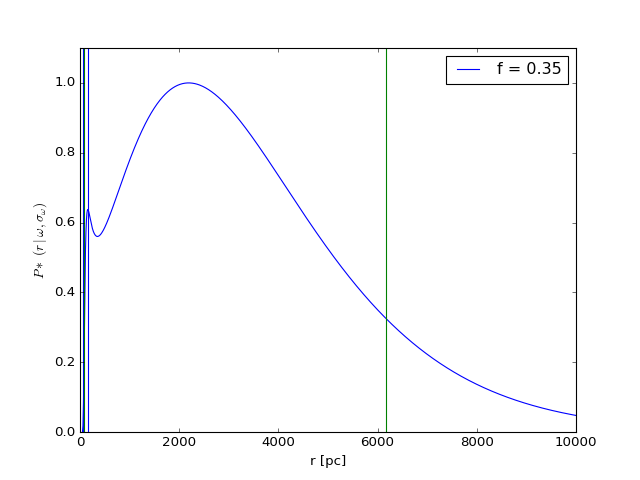

In [34]:
r = np.linspace(50,10000,1e3-1)

post = (r**2*np.exp(-r/L)/final['parallax_error'].values[999952]/1000)*\
    np.exp((-1/(2*(final['parallax_error'].values[999952]/1000)**2))*(final['parallax'].values[999952]/1000-(1/r))**2)
#post2 = (r**2*np.exp(-r/L)/final['parallax_error'].values[4643]/1000)*\
#    np.exp((-1/(2*(final['parallax_error'].values[4643]/1000)**2))*(final['parallax'].values[4643]/1000-(1/r))**2)

%matplotlib notebook
plt.plot(r,post/np.max(post),label='f = {0}'.format(0.35))
#plt.plot(r,post2/np.max(post2),label='f = {0}'.format(0.1),color='green')
plt.axvline(x=final['dist_95ci_lo'].values[999952])
plt.axvline(x=final['dist_95ci_hi'].values[999952])
plt.axvline(x=final['dist_fwhm_lo'].values[999952],color='green')
plt.axvline(x=final['dist_fwhm_hi'].values[999952],color='green')
#plt.axvline(x=final['dist'].values[17712]+twosigma,color='red')
#plt.axvline(x=final['dist'].values[17712]-twosigma,color='red')
#plt.axvline(x=final['dist'].values[4643]+twosigma,color='orange')
#plt.axvline(x=final['dist'].values[4643]-twosigma,color='orange')
plt.ylim(0,1.1)
plt.legend()
plt.ylabel('$P*\;(r \mid \omega , \sigma_{\omega})$')
plt.xlabel('r [pc]')
plt.show()

The green line is the FWHM hi/lo, and and the blue is MCMC 95% CI hi/lo.  There are two maxima in this posterior, one ~2000 pc and one ~150 pc.  The MCMC stayed within the local maxima nicely, while the FWHM encompasses the entire posterior.  I checked this against the methods of B-J15 (https://arxiv.org/pdf/1507.02105.pdf) from which this is derived.  He lays out the case that there is a possibility that the roots of the distance estimator polynomial might be three positive roots, correponding to two maxima and one minimum, which is the case here.  He gives an arguement for selecting the smallest root as the distance estimator in this case (pg 14 & 15), if the parallax is positive, which we have here.  He says:<br>
"I continue to use the mode at the lower value of r as the
distance estimator, because we can think of this one as being dominated by the data: it continues to
evolve smoothly from the data-dominated regime (small ftrue)... [when the second mode appears] [t]his corresponds to the “data-dominated” mode disappearing,
leaving only the other,“prior-dominated”, mode for all larger values of ftrue... Whenever we have two modes, it is always
the smaller one which is dictated by the data, so we can always make the correct choice of distance
estimator."

So, yes.  This is correct according to his methodology.  

In [254]:
# The roots of the polynomial:
coeff = np.array([(1./L),(-2),((final['parallax'].values[999952]/1000)/((final['parallax_error'].values[999952]/1000)**2)),\
                  -(1./((final['parallax_error'].values[999952]/1000)**2))])
g = np.roots(coeff)
print g
print final['parallax'].values[999952]

[ 2190.64575552   351.77963444   157.57461004]
9.64537518804


So what happened with FWHM?<br>
I couldn't find a discussion on FWHM in any Bailer-Jones paper.  But it was computed using his methodology found here (https://repos.cosmos.esa.int/socci/projects/GAIA/repos/astrometry-inference-tutorials/browse/single-source/tutorial/Rcode/distance_functions.R?at=2c11dda5bf13cf0a52ce4f9c2eb586c83abf9cb8  Line 144) using root finding.  It appears that this method found the FWHM corresponding to the larger prior-driven root.  If I restrict the max distance to localize the root finding around the smaller local maximum, it doesn't even find that maxmimum.  This equation as written only seems to work for finding FWHM around the absolute maxmimum and not local maxima.<br>
So FWHM should just be disregarded for high f solutions.

In [140]:
# Finding the root of the FWHM equation:
rmode = 157.57
rmax = 1e6
L=1350
M = (rmode**2*np.exp(-rmode/L)/pp['parallax_error'].values[999952]/1000)*np.exp((-1./(2*(pp['parallax_error'].values[999952]/1000)**2))*(pp['parallax'].values[999952]/1000-(1./rmode))**2)

lo = brentq(lambda x: 2*np.log(x)-(x/L)-(((pp['parallax'].values[999952]/1000-(1./x))**2)/(2*pp['parallax_error'].values[999952]/1000**2)) \
            +np.log(2)-np.log(M)-np.log(pp['parallax_error'].values[999952]/1000), 0.001, rmode)

hi = brentq(lambda x: 2*np.log(x)-(x/L)-(((pp['parallax'].values[999952]/1000-(1./x))**2)/(2*pp['parallax_error'].values[999952]/1000**2)) \
            +np.log(2)-np.log(M)-np.log(pp['parallax_error'].values[999952]/1000), rmode, rmax)
print lo,hi

52.8619677746 13956.245863


# CMD troubleshooting:
What causes the blob at the bottom?

In [100]:
# GBP - GRP color:
color = final['bp_rp'].values
# Apparent G band magnitude:
gmag = final['phot_g_mean_mag'].values 

# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(final['parallax'].values/1000)

<IPython.core.display.Javascript object>


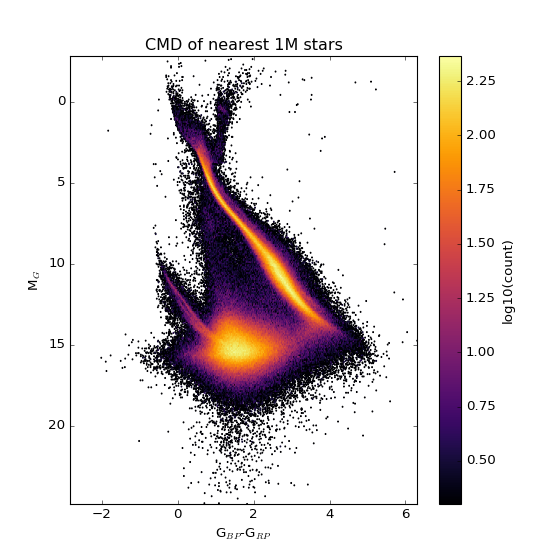

In [70]:
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
#fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)

#ax = axs[0]
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars")
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')

plt.show()
plt.savefig('nearest_1M_cmd.jpg', dpi=300, format='jpg')

<IPython.core.display.Javascript object>


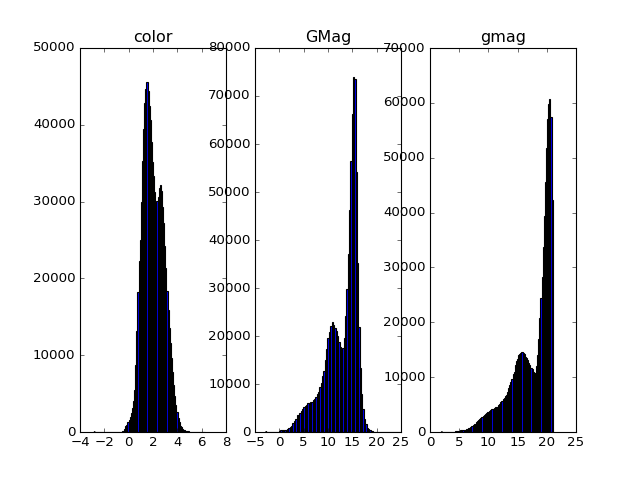

In [310]:
%matplotlib notebook
plt.subplot(131)
plt.title('color')
plt.hist(color,bins=100)
plt.subplot(132)
plt.title('GMag')
plt.hist(GMag,bins=100)
plt.subplot(133)
plt.title('gmag')
plt.hist(gmag,bins=100)
plt.show()

(193698,)
Percent w/ 15<GMag<16 with sig noise: 0.799869508841
(9480,)
Percent w/ 0<GMag<5 with sig noise: 0.272554769708



<IPython.core.display.Javascript object>


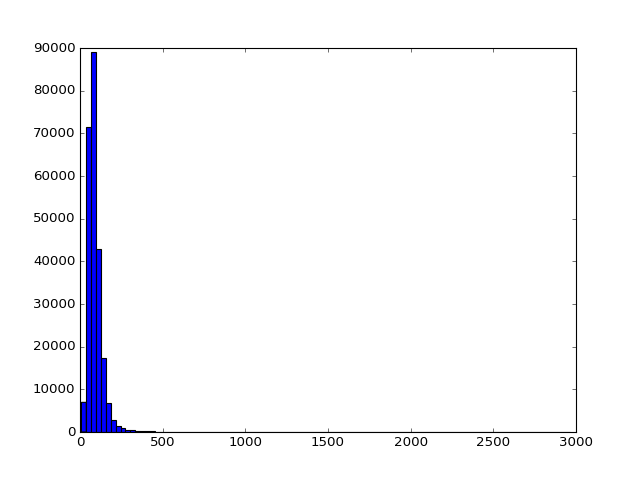

In [321]:
#print np.where((GMag<16)&(GMag>15))[0].shape[0]
#print final['astrometric_excess_noise_sig'].values[np.where((GMag<16)&(GMag>15))[0]]
D1 = final['astrometric_excess_noise_sig'].values[np.where((GMag<16)&(GMag>15))[0]]
print np.where(D1>=2)[0].shape
print 'Percent w/ 15<GMag<16 with sig noise:',float(np.where(D1>=2)[0].shape[0])/float(D1.shape[0])
D2 = final['astrometric_excess_noise_sig'].values[np.where((GMag<5)&(GMag>0))[0]]
print np.where(D2>=2)[0].shape
print 'Percent w/ 0<GMag<5 with sig noise:',float(np.where(D2>=2)[0].shape[0])/float(D2.shape[0])
print ''
%matplotlib notebook
plt.hist(final['phot_g_mean_flux_over_error'].values[np.where((GMag<16)&(GMag>15))[0]],bins=100)
plt.show()

What if I apply the cuts from the Gaia HRD paper:

In [325]:
# Cut: parallax over error better than 20% (the HRD paper uses 10% conservatively)
o=final.drop(np.where(final['parallax_over_error'].values>20)[0],axis=0)
o=o.reset_index()
o = o.drop(['index'], axis=1)
print o.shape

(539220, 100)


<IPython.core.display.Javascript object>


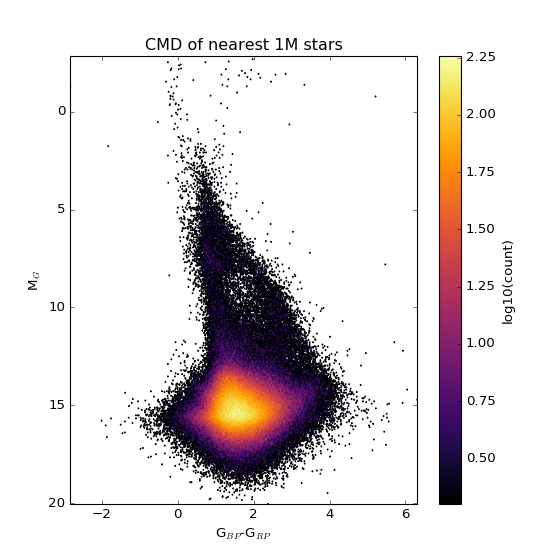

In [326]:
# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars")
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.show()

So I accidentally did this wrong and dropped all the sources with para_over_error more than 20, when I needed to drop para_over_error less than 20.  Because a higher number means better parallax solution.

But look - we've isolated the problem area.  So this is looking promising.  Doing the right thing:

In [71]:
# Cut: parallax over error better than 20% (the HRD paper uses 10% conservatively)
o=final.drop(np.where(final['parallax_over_error'].values<20)[0],axis=0)
o=o.reset_index()
o = o.drop(['index'], axis=1)
print o.shape

(460780, 101)


<IPython.core.display.Javascript object>


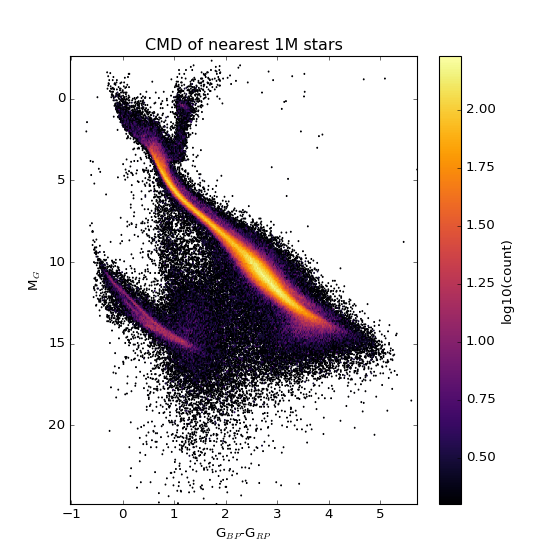

In [72]:
# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars")
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.show()
plt.savefig('nearest_1M_cmd_highqualitycut.jpg', dpi=300, format='jpg')

Yep that removed the problem for the most part.

Let's try other cuts.

(473770, 100)


<IPython.core.display.Javascript object>


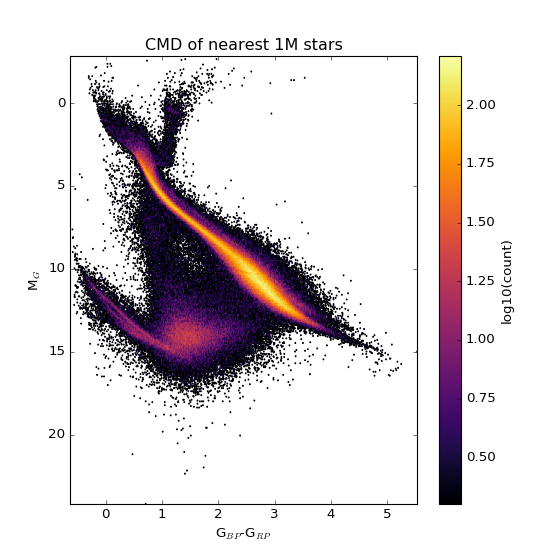

In [336]:
# Cut: drop mean g flux over error less than 50 - this encapsulates large errors in the g mag term
o=final.drop(np.where(final['phot_g_mean_flux_over_error'].values<50)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
o=o.drop(np.where(o['phot_rp_mean_flux_over_error'].values<20)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
o=o.drop(np.where(o['phot_bp_mean_flux_over_error'].values<20)[0],axis=0)
o=o.reset_index()
o = o.drop(['index'], axis=1)
print o.shape

# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars")
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.show()

So that did a decent job (but I still see some hanging out in the (2,15) area.)

(891513, 100)


<IPython.core.display.Javascript object>


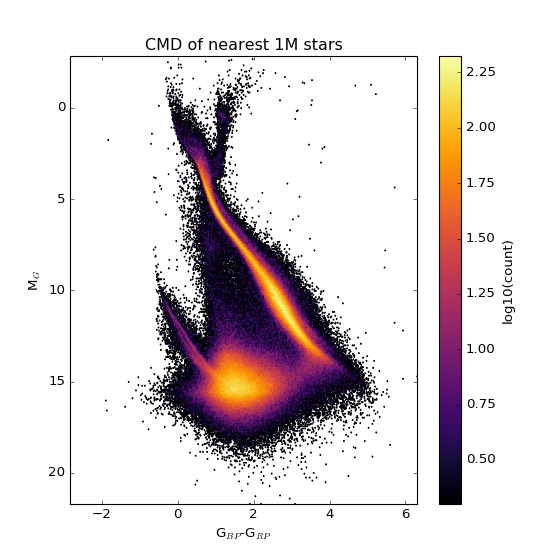

In [337]:
#Cut: use sources with only a large number of visibility periods (higher N -> lower uncert), more than 8
o=final.drop(np.where(final['visibility_periods_used'].values<8)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
print o.shape

# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars")
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.show()

Didn't make much difference

In [340]:
# Cut: The chi2 criterion of Lindegren+ 2018
v1 = np.sqrt(final['astrometric_chi2_al'].values/(final['astrometric_n_good_obs_al'].values-5))
v2=np.zeros(len(v1))
for i in range(len(v1)):
    v2[i] = 1.2*max(1,np.exp(-0.2*(final['phot_g_mean_mag'].values[i]-19.5)))
print v2

[ 9.89074189  1.2         1.2        ...,  1.2         1.2         1.2       ]


In [342]:
print np.where(v2<v1)[0].shape

(499904,)


(500096, 100)


<IPython.core.display.Javascript object>


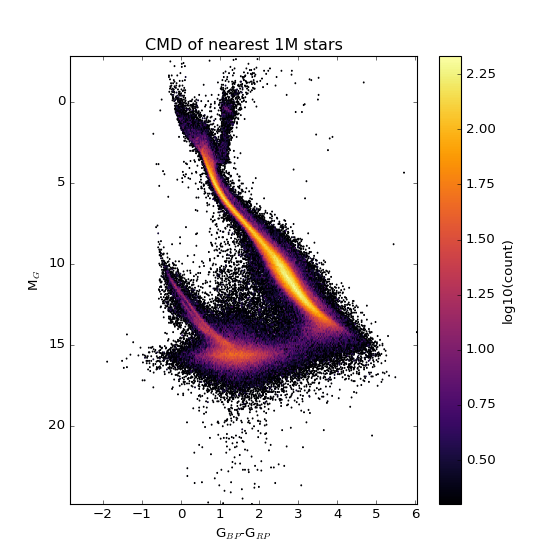

In [344]:
o=final.drop(np.where(v2<v1)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
print o.shape

# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars")
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.show()

Also good, but not as good as the parallax quality.

Let's put them all together

(460780, 103)
(444533, 103)
(389236, 103)
(360788, 103)


<IPython.core.display.Javascript object>


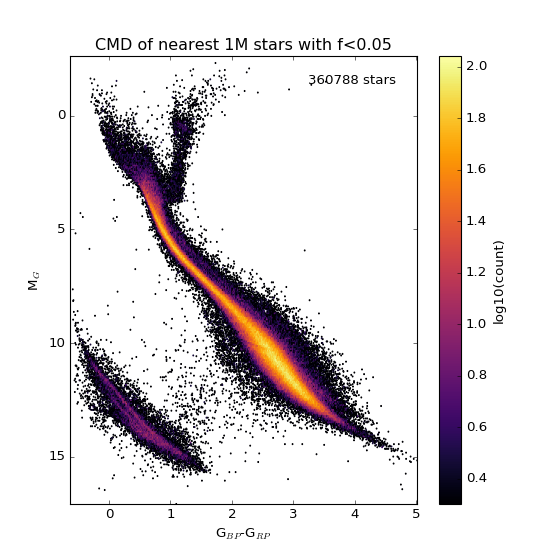

In [69]:
# Cut: parallax over error better than 10% (the HRD paper uses 10% conservatively)
#o=final.drop(np.where(final['parallax_over_error'].values<20)[0],axis=0)
cut = 20
o=final.drop(np.where(final['parallax_over_error'].values<cut)[0],axis=0)
o=o.reset_index()
o = o.drop(['index'], axis=1)
print o.shape

o=o.drop(np.where(o['visibility_periods_used'].values<8)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
print o.shape

o=o.drop(np.where(o['phot_g_mean_flux_over_error'].values<50)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
o=o.drop(np.where(o['phot_rp_mean_flux_over_error'].values<20)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
o=o.drop(np.where(o['phot_bp_mean_flux_over_error'].values<20)[0],axis=0)
o=o.reset_index()
o = o.drop(['index'], axis=1)
print o.shape

v1 = np.sqrt(o['astrometric_chi2_al'].values/(o['astrometric_n_good_obs_al'].values-5))
v2=np.zeros(len(v1))
for i in range(len(v1)):
    v2[i] = 1.2*max(1,np.exp(-0.2*(o['phot_g_mean_mag'].values[i]-19.5)))
o=o.drop(np.where(v2<v1)[0],axis=0)
o=o.reset_index()
o=o.drop(['index'], axis=1)
print o.shape



# GBP - GRP color:
color = o['bp_rp'].values
# Apparent G band magnitude:
gmag = o['phot_g_mean_mag'].values 
# Convert to absolute magnitude (excluding extinction for now):
GMag = gmag + 5 + 5*np.log10(o['parallax'].values/1000)
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(7, 7))
hb = ax.hexbin(color,GMag,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.set_title("CMD of nearest 1M stars with f<{0}".format(np.round(1./cut,decimals=3)))
ax.set_ylabel('M$_{G}$')
ax.set_xlabel('G$_{BP}$-G$_{RP}$')
ax.invert_yaxis()
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(count)')
plt.annotate('{0} stars'.format(o.shape[0]),xy=(0.55,0.85),xycoords='figure fraction')
plt.show()
#plt.savefig('nearest_1M_cmd_highqualitycut_f0005.jpg', dpi=300, format='jpg')

#### Does quality corrleate with distance? Magnitude?

<IPython.core.display.Javascript object>


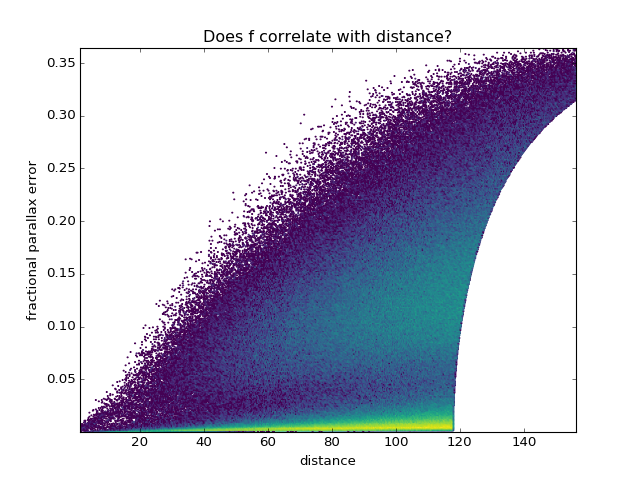

In [88]:
%matplotlib notebook
plt.hexbin(final['dist'],final['frac_para_error'],gridsize=500,cmap='viridis',bins='log',mincnt=1)
plt.xlabel('distance')
plt.ylabel('fractional parallax error')
plt.title('Does f correlate with distance?')
plt.show()

<IPython.core.display.Javascript object>


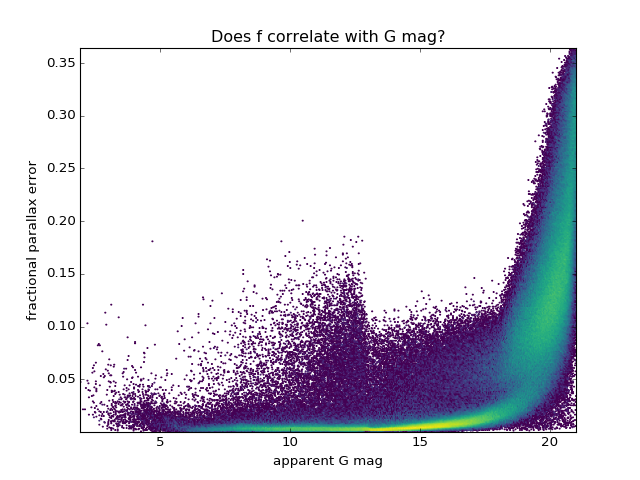

In [89]:
%matplotlib notebook
plt.hexbin(final['phot_g_mean_mag'],final['frac_para_error'],gridsize=500,cmap='viridis',bins='log',mincnt=1)
plt.xlabel('apparent G mag')
plt.ylabel('fractional parallax error')
plt.title('Does f correlate with G mag?')
plt.show()

This looks just like the plot of sigma(G) vs G mag in A&B-J Paper 2: http://iopscience.iop.org/article/10.3847/0004-637X/832/2/137/pdf  So the f correlates with G mag in the same way that G mag error correleates with G mag

<IPython.core.display.Javascript object>


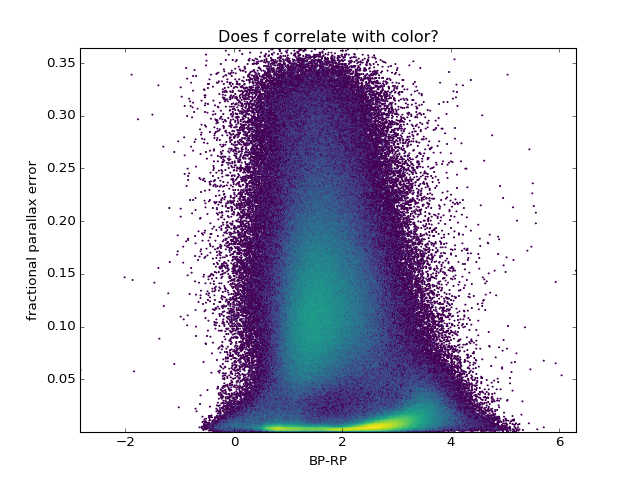

In [90]:
%matplotlib notebook
plt.hexbin(final['bp_rp'],final['frac_para_error'],gridsize=500,cmap='viridis',bins='log',mincnt=1)
plt.xlabel('BP-RP')
plt.ylabel('fractional parallax error')
plt.title('Does f correlate with color?')
plt.show()